# Capstone Project - League of Legends Champion Recommender

> Author: Ryan Yong

**Summary:**   
- Develop a Recommender System for recommending champions to users based on their account mastery points.
- Training data: Account & Champion Data

There are a total of 7 notebooks for this project:  
 1. `01a_data_scrape.ipynb`   
 2. `01b_wiki_scrape_fail.ipynb`   
 3. `02_champion_dataset_EDA.ipynb`
 4. `03_account_dataset_EDA.ipynb`
 5. `04_intial_recommender_system.ipynb`
 6. `05_final_hybrid_system.ipynb`
 7. `06_implementation.ipynb`

---
**This Notebook**
- shows the final hybrid recommendation model
- uses both `engineered_champion_data.csv` & `account_rank_mastery_dataset.csv` to calculate the recommendation 

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from scipy.linalg import svd
from sklearn.metrics import r2_score

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
# Load the dataset
mastery_data_with_rank = pd.read_csv('../data/account_rank_mastery_dataset.csv')
champion_features = pd.read_csv('../data/champion_features.csv')

In [3]:
mastery_data_with_rank.head()

,rank,Aatrox,Ahri,Akali,Akshan,Alistar,Amumu,Anivia,Annie,Aphelios,Ashe,Aurelion Sol,Azir,Bard,Bel'Veth,Blitzcrank,Brand,Braum,Briar,Caitlyn,Camille,Cassiopeia,Cho'Gath,Corki,Darius,Diana,Dr. Mundo,Draven,Ekko,Elise,Evelynn,Ezreal,Fiddlesticks,Fiora,Fizz,Galio,Gangplank,Garen,Gnar,Gragas,Graves,Gwen,Hecarim,Heimerdinger,Hwei,Illaoi,Irelia,Ivern,Janna,Jarvan IV,Jax,Jayce,Jhin,Jinx,K'Sante,Kai'Sa,Kalista,Karma,Karthus,Kassadin,Katarina,Kayle,Kayn,Kennen,Kha'Zix,Kindred,Kled,Kog'Maw,LeBlanc,Lee Sin,Leona,Lillia,Lissandra,Lucian,Lulu,Lux,Malphite,Malzahar,Maokai,Master Yi,Milio,Miss Fortune,Mordekaiser,Morgana,Naafiri,Nami,Nasus,Nautilus,Neeko,Nidalee,Nilah,Nocturne,Nunu & Willump,Olaf,Orianna,Ornn,Pantheon,Poppy,Pyke,Qiyana,Quinn,Rakan,Rammus,Rek'Sai,Rell,Renata Glasc,Renekton,Rengar,Riven,Rumble,Ryze,Samira,Sejuani,Senna,Seraphine,Sett,Shaco,Shen,Shyvana,Singed,Sion,Sivir,Skarner,Smolder,Sona,Soraka,Swain,Sylas,Syndra,Tahm Kench,Taliyah,Talon,Taric,Teemo,Thresh,Tristana,Trundle,Tryndamere,Twisted Fate,Twitch,Udyr,Urgot,Varus,Vayne,Veigar,Vel'Koz,Vex,Vi,Viego,Viktor,Vladimir,Volibear,Warwick,Wukong,Xayah,Xerath,Xin Zhao,Yasuo,Yone,Yorick,Yuumi,Zac,Zed,Zeri,Ziggs,Zilean,Zoe,Zyra
0,10,3253.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7909.0,0.0,0.0,0.0,1620.0,51478.0,0.0,1142.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2629.0,1853.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,920.0,0.0,0.0,106.0,0.0,1119.0,615.0,0.0,0.0,0.0,0.0,2237.0,918.0,0.0,0.0,0.0,0.0,0.0,4855.0,0.0,0.0,0.0,0.0,865.0,1810.0,0.0,0.0,0.0,0.0,0.0,22955.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7237.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,179.0,0.0,0.0,0.0,0.0,146.0,0.0,0.0,0.0,0.0,0.0,0.0,24524.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,537.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,119.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5113.0,0.0,0.0,0.0,0.0,0.0,105881.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10,78536.0,95438.0,47494.0,9391.0,23242.0,24820.0,2932.0,102068.0,135475.0,103526.0,5077.0,21179.0,14260.0,165.0,72825.0,20315.0,23163.0,0.0,197115.0,120748.0,27261.0,9838.0,8029.0,58001.0,40500.0,4479.0,741222.0,55192.0,19696.0,48476.0,592043.0,26997.0,76494.0,32387.0,18639.0,53324.0,24742.0,42443.0,37766.0,84864.0,6417.0,30413.0,18064.0,1140.0,847.0,106033.0,635.0,136642.0,36047.0,25134.0,63179.0,227294.0,314765.0,181.0,301951.0,104240.0,111944.0,31301.0,37939.0,82707.0,29148.0,55187.0,13436.0,95992.0,8600.0,10365.0,63593.0,136995.0,278103.0,28987.0,1390.0,32312.0,378550.0,18868.0,46961.0,37025.0,2257.0,34973.0,55276.0,0.0,105882.0,7602.0,99959.0,0.0,15947.0,10974.0,8166.0,32967.0,122239.0,1084.0,3850.0,35554.0,5224.0,18609.0,225.0,18444.0,1475.0,82628.0,44516.0,38032.0,38108.0,19588.0,4111.0,0.0,0.0,4584.0,153749.0,293369.0,15261.0,34745.0,82601.0,25263.0,45979.0,1776.0,3110.0,31962.0,200.0,20723.0,8576.0,9356.0,114772.0,10293.0,37920.0,28988.0,44045.0,34060.0,55465.0,66238.0,128.0,58390.0,11784.0,1314.0,42318.0,170216.0,116166.0,3610.0,6073.0,45525.0,106558.0,1930.0,1649.0,158713.0,490090.0,24911.0,11026.0,2940.0,26555.0,8151.0,4263.0,85177.0,2558.0,8599.0,18688.0,250566.0,60256.0,16235.0,231319.0,18132.0,566.0,114066.0,44888.0,273789.0,22772.0,38333.0,10955.0,97182.0,11015.0
2,10,58213.0,3055.0,49768.0,163123.0,8625.0,4000.0,7938.0,3409.0,13233.0,6039.0,14463.0,19801.0,3983.0,0.0,55679.0,12583.0,0.0,0.0,114667.0,108146.0,15890.0,17476.0,7107.0,22225.0,9325.0,8505.0,221838.0,117358.0,22517.0,19383.0,46981.0,4269.0,105244.0,27665.0,6252.0,79150.0,15539.0,1958.0,19937.0,90408.0,8014.0,30969.0,1565.0,0.0,1259.0,83637.0,0.0,2562.0,27250.0,161338.0,26977.0,122035.0,61557.0,10678.0,162875.0,14943.0,375.0,17724.0,81323.0,265722.0,15012.0,80166.0,5084.0,113607.0,19483.0,0.0,9822.0,57413.0,479823.0,2182.0,6613.0,10326.0,114779.0,558.0,21902.0,11510.0,915.0,0.0,78870.0,146.0,1564.0,354.0,502.0,0.0,0.0,88956.0,0.0,212.0,41820.0,3533.0,6096.0,1974.0,1051.0,39409.0,95.0,7687.0,1085.0,26426.0,54277.0,3748.0,9227.0,41777.0,7963.0,0.0,6

Check `mastery_data_with_rank` for sparsity to determine which SVD model to use. 

In [4]:
# Calculate the total number of elements
total_elements = mastery_data_with_rank.size

# Calculate the number of non-zero elements
non_zero_elements = (mastery_data_with_rank != 0).sum().sum()

# Calculate the number of zero elements
zero_elements = total_elements - non_zero_elements

# Calculate the sparsity ratio
sparsity_ratio = zero_elements / total_elements

print(f"Total elements: {total_elements}")
print(f"Non-zero elements: {non_zero_elements}")
print(f"Zero elements: {zero_elements}")
print(f"Sparsity ratio: {sparsity_ratio:.2f}")

# Depending on your threshold, you might consider a dataset as sparse if, say, the sparsity_ratio is > 0.5 (50% of mastery_data_with_rank is zeros)


Total elements: 905856
Non-zero elements: 737458
Zero elements: 168398
Sparsity ratio: 0.19


Based on a 0.19 Sparsity ratio, it is determined that the dataset is not sparse. Therefore a Truncated SVD model will be used

In [5]:
train_data_with_rank, test_data_with_rank = train_test_split(mastery_data_with_rank,test_size=0.2, stratify=mastery_data_with_rank['rank'])

print(train_data_with_rank['rank'].value_counts())
print(test_data_with_rank['rank'].value_counts())

rank
2     656
3     656
4     656
1     656
6     656
5     656
8     257
9      80
10     40
Name: count, dtype: int64
rank
1     164
3     164
4     164
6     164
2     164
5     164
8      65
9      20
10     10
Name: count, dtype: int64


In [6]:
# Columns to transform (all except 'rank')
columns_to_transform = train_data_with_rank.columns.drop('rank')

# Apply log transformation
train_data_with_rank[columns_to_transform] = np.log1p(train_data_with_rank[columns_to_transform])

# Scale the data
scaler = StandardScaler()
train_data_with_rank[columns_to_transform] = scaler.fit_transform(train_data_with_rank[columns_to_transform])

# Check the transformed data
train_data_with_rank.head()


,rank,Aatrox,Ahri,Akali,Akshan,Alistar,Amumu,Anivia,Annie,Aphelios,Ashe,Aurelion Sol,Azir,Bard,Bel'Veth,Blitzcrank,Brand,Braum,Briar,Caitlyn,Camille,Cassiopeia,Cho'Gath,Corki,Darius,Diana,Dr. Mundo,Draven,Ekko,Elise,Evelynn,Ezreal,Fiddlesticks,Fiora,Fizz,Galio,Gangplank,Garen,Gnar,Gragas,Graves,Gwen,Hecarim,Heimerdinger,Hwei,Illaoi,Irelia,Ivern,Janna,Jarvan IV,Jax,Jayce,Jhin,Jinx,K'Sante,Kai'Sa,Kalista,Karma,Karthus,Kassadin,Katarina,Kayle,Kayn,Kennen,Kha'Zix,Kindred,Kled,Kog'Maw,LeBlanc,Lee Sin,Leona,Lillia,Lissandra,Lucian,Lulu,Lux,Malphite,Malzahar,Maokai,Master Yi,Milio,Miss Fortune,Mordekaiser,Morgana,Naafiri,Nami,Nasus,Nautilus,Neeko,Nidalee,Nilah,Nocturne,Nunu & Willump,Olaf,Orianna,Ornn,Pantheon,Poppy,Pyke,Qiyana,Quinn,Rakan,Rammus,Rek'Sai,Rell,Renata Glasc,Renekton,Rengar,Riven,Rumble,Ryze,Samira,Sejuani,Senna,Seraphine,Sett,Shaco,Shen,Shyvana,Singed,Sion,Sivir,Skarner,Smolder,Sona,Soraka,Swain,Sylas,Syndra,Tahm Kench,Taliyah,Talon,Taric,Teemo,Thresh,Tristana,Trundle,Tryndamere,Twisted Fate,Twitch,Udyr,Urgot,Varus,Vayne,Veigar,Vel'Koz,Vex,Vi,Viego,Viktor,Vladimir,Volibear,Warwick,Wukong,Xayah,Xerath,Xin Zhao,Yasuo,Yone,Yorick,Yuumi,Zac,Zed,Zeri,Ziggs,Zilean,Zoe,Zyra
4496,2,0.290690,0.237199,-0.108177,0.447477,0.244381,-1.021375,-1.796894,0.056296,-1.722181,0.606760,-1.814782,-1.827413,-0.410781,1.160154,-0.018712,-2.710442,-1.715666,-0.909334,-3.749478,-0.402474,0.094438,-0.288127,-1.567075,0.288992,-0.588677,-2.099245,-2.065125,-0.047961,-0.059631,-1.999514,-0.901819,0.399925,0.408958,-1.947242,0.620477,-1.842770,-0.171601,-0.144433,-1.851431,-0.602084,0.363356,-0.041736,1.463784,-0.908007,0.347382,-2.524998,0.071753,-1.752087,-0.140445,0.157027,0.299692,-3.272096,-3.064276,1.504686,-0.933168,-1.810420,-2.357178,0.185522,0.626233,-2.160681,-0.119957,-2.283589,-0.114554,-2.181527,-1.993551,-1.203276,-1.783379,-2.075911,-0.581836,-2.312328,0.228730,-1.632277,-0.134878,-1.923225,-3.809325,-3.009753,-1.675941,1.073333,-3.284441,0.363396,0.412548,1.002306,-3.051579,-0.846861,-1.579999,0.530712,0.540840,-1.782182,-2.109321,0.257340,-1.929637,-0.167020,0.114261,-1.814553,-1.733706,0.539400,-1.904483,-0.062309,0.644620,-0.531473,0.660367,-1.924793,-1.387289,-1.168204,0.627838,0.480481,0.131225,-2.283122,-0.229111,0.034933,0.585851,-1.570575,0.514218,1.238862,0.516261,-2.023922,-1.852848,-1.607529,0.527963,0.965457,-0.358445,-1.245395,-0.919065,-2.034028,-0.175291,0.127192,0.639386,-1.963277,-1.831974,-0.017384,0.424877,0.211095,0.166478,-2.865120,-2.726052,0.441350,0.097713,-2.538728,-2.762060,0.670726,-1.594940,-2.763515,-0.324524,0.818172,-1.935007,0.646603,-1.921195,0.685253,-1.784199,-2.099403,-0.584728,-0.174012,0.417782,-0.007017,-2.086613,-0.024709,-1.483885,-0.086068,-0.066605,1.141863,-1.696949,-2.526731,0.290108,-1.782569,0.937028,-1.682464,-1.575900
3404,3,0.985892,0.210456,0.342987,-1.411592,0.490359,-2.537528,0.293207,0.213003,0.185357,-0.233288,0.937763,0.919928,0.598136,1.106258,0.210911,0.080152,0.848853,-0.909334,0.387160,-0.040307,-1.687257,0.210436,0.665536,-1.032742,-0.775922,-0.166432,0.279217,0.352963,0.616290,0.560920,0.175347,0.541235,-0.858238,-1.947242,0.652395,0.850891,0.542719,0.622404,0.373678,0.309641,1.151414,0.544533,0.508230,-0.908007,0.240745,0.187689,0.742541,0.334555,0.476851,0.426262,0.733904,0.663161,-0.288371,-1.191771,0.428408,-1.810420,-0.208127,0.509310,0.480478,-0.216754,0.362900,0.507157,0.571902,0.214090,1.492510,0.839582,0.055617,-0.231823,-0.295326,0.464853,0.609693,-1.632277,-0.056645,-1.923225,-0.090948,0.365300,0.647437,0.494999,0.177380,-0.895175,-1.278488,1.029821,-0.146067,-0.846861,0.005202,0.494200,0.456893,0.477600,-0.168199,-1.066315,0.383643,0.362979,0.722802,0.454612,0.772953,0.624769,0.284702,0.667240,0.802613,-1.675078,0.726199,0.459818,0.784731,0.371297,-1.178766,0.694573,0.088146,-2.283122,0.579524,0.757138,-0.034721,0.639437,-0.058572,0.215323,0.676290,0.557518,0.806119,0.290199,0.858418,0.820683,0.010529,1.153966,-0.919065,0.462285,-0.025218,0.375208,0.610561,-

In [7]:
train_mastery_data = train_data_with_rank.drop('rank', axis=1)

train_mastery_data.shape

(4313, 167)

k here is determined using cumulative explained variance, determine the k value required to explain 90% of the cumulative explained variance. This is to reduce dimensionalty

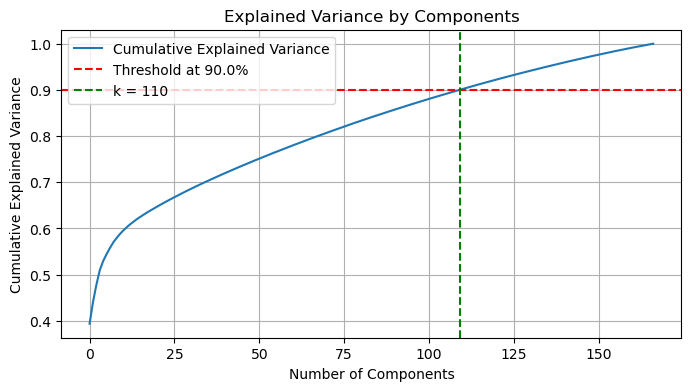

Number of components needed for at least 90.0% explained variance: 110


In [8]:
# Perform SVD using SciPy's svd function with economic SVD option
U, s, Vt = svd(train_mastery_data, full_matrices=False)

# Calculate the total variance from the singular values
total_variance = np.sum(s**2)

# Calculate the explained variance for each singular value
explained_variance = (s**2) / total_variance

# Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance)

# Define a threshold for cumulative explained variance (e.g., 90%)
threshold = 0.90

# Determine the minimum number of components needed to reach the threshold
k = np.argmax(cumulative_explained_variance >= threshold) + 1  # +1 because indices start at 0

# Plotting the cumulative explained variance to visualize performance
plt.figure(figsize=(8, 4))
plt.plot(cumulative_explained_variance, label='Cumulative Explained Variance')
plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold at {threshold * 100}%')
plt.axvline(x=k-1, color='g', linestyle='--', label=f'k = {k}')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.legend()
plt.grid(True)
plt.show()

# Print the number of components that meet the threshold
print(f"Number of components needed for at least {threshold*100}% explained variance: {k}")


using k = 110, fits and transforms the data using `TruncatedSVD`

In [9]:
k = 110
svd = TruncatedSVD(n_components=k)

# Fit and transform the data
U_k = svd.fit_transform(train_mastery_data)  # This computes U * Sigma
s_k = svd.singular_values_             # Only the singular values
Vt_k = svd.components_                 # This is V^T

# Shapes of the components
print(U_k.shape)  # This will be (n_samples, k)
print(s_k.shape)  # This will be (k,)
print(Vt_k.shape) # This will be (k, n_features

(4313, 111)
(111,)
(111, 167)


In [10]:
train_mastery_data.head()

,Aatrox,Ahri,Akali,Akshan,Alistar,Amumu,Anivia,Annie,Aphelios,Ashe,Aurelion Sol,Azir,Bard,Bel'Veth,Blitzcrank,Brand,Braum,Briar,Caitlyn,Camille,Cassiopeia,Cho'Gath,Corki,Darius,Diana,Dr. Mundo,Draven,Ekko,Elise,Evelynn,Ezreal,Fiddlesticks,Fiora,Fizz,Galio,Gangplank,Garen,Gnar,Gragas,Graves,Gwen,Hecarim,Heimerdinger,Hwei,Illaoi,Irelia,Ivern,Janna,Jarvan IV,Jax,Jayce,Jhin,Jinx,K'Sante,Kai'Sa,Kalista,Karma,Karthus,Kassadin,Katarina,Kayle,Kayn,Kennen,Kha'Zix,Kindred,Kled,Kog'Maw,LeBlanc,Lee Sin,Leona,Lillia,Lissandra,Lucian,Lulu,Lux,Malphite,Malzahar,Maokai,Master Yi,Milio,Miss Fortune,Mordekaiser,Morgana,Naafiri,Nami,Nasus,Nautilus,Neeko,Nidalee,Nilah,Nocturne,Nunu & Willump,Olaf,Orianna,Ornn,Pantheon,Poppy,Pyke,Qiyana,Quinn,Rakan,Rammus,Rek'Sai,Rell,Renata Glasc,Renekton,Rengar,Riven,Rumble,Ryze,Samira,Sejuani,Senna,Seraphine,Sett,Shaco,Shen,Shyvana,Singed,Sion,Sivir,Skarner,Smolder,Sona,Soraka,Swain,Sylas,Syndra,Tahm Kench,Taliyah,Talon,Taric,Teemo,Thresh,Tristana,Trundle,Tryndamere,Twisted Fate,Twitch,Udyr,Urgot,Varus,Vayne,Veigar,Vel'Koz,Vex,Vi,Viego,Viktor,Vladimir,Volibear,Warwick,Wukong,Xayah,Xerath,Xin Zhao,Yasuo,Yone,Yorick,Yuumi,Zac,Zed,Zeri,Ziggs,Zilean,Zoe,Zyra
4496,0.290690,0.237199,-0.108177,0.447477,0.244381,-1.021375,-1.796894,0.056296,-1.722181,0.606760,-1.814782,-1.827413,-0.410781,1.160154,-0.018712,-2.710442,-1.715666,-0.909334,-3.749478,-0.402474,0.094438,-0.288127,-1.567075,0.288992,-0.588677,-2.099245,-2.065125,-0.047961,-0.059631,-1.999514,-0.901819,0.399925,0.408958,-1.947242,0.620477,-1.842770,-0.171601,-0.144433,-1.851431,-0.602084,0.363356,-0.041736,1.463784,-0.908007,0.347382,-2.524998,0.071753,-1.752087,-0.140445,0.157027,0.299692,-3.272096,-3.064276,1.504686,-0.933168,-1.810420,-2.357178,0.185522,0.626233,-2.160681,-0.119957,-2.283589,-0.114554,-2.181527,-1.993551,-1.203276,-1.783379,-2.075911,-0.581836,-2.312328,0.228730,-1.632277,-0.134878,-1.923225,-3.809325,-3.009753,-1.675941,1.073333,-3.284441,0.363396,0.412548,1.002306,-3.051579,-0.846861,-1.579999,0.530712,0.540840,-1.782182,-2.109321,0.257340,-1.929637,-0.167020,0.114261,-1.814553,-1.733706,0.539400,-1.904483,-0.062309,0.644620,-0.531473,0.660367,-1.924793,-1.387289,-1.168204,0.627838,0.480481,0.131225,-2.283122,-0.229111,0.034933,0.585851,-1.570575,0.514218,1.238862,0.516261,-2.023922,-1.852848,-1.607529,0.527963,0.965457,-0.358445,-1.245395,-0.919065,-2.034028,-0.175291,0.127192,0.639386,-1.963277,-1.831974,-0.017384,0.424877,0.211095,0.166478,-2.865120,-2.726052,0.441350,0.097713,-2.538728,-2.762060,0.670726,-1.594940,-2.763515,-0.324524,0.818172,-1.935007,0.646603,-1.921195,0.685253,-1.784199,-2.099403,-0.584728,-0.174012,0.417782,-0.007017,-2.086613,-0.024709,-1.483885,-0.086068,-0.066605,1.141863,-1.696949,-2.526731,0.290108,-1.782569,0.937028,-1.682464,-1.575900
3404,0.985892,0.210456,0.342987,-1.411592,0.490359,-2.537528,0.293207,0.213003,0.185357,-0.233288,0.937763,0.919928,0.598136,1.106258,0.210911,0.080152,0.848853,-0.909334,0.387160,-0.040307,-1.687257,0.210436,0.665536,-1.032742,-0.775922,-0.166432,0.279217,0.352963,0.616290,0.560920,0.175347,0.541235,-0.858238,-1.947242,0.652395,0.850891,0.542719,0.622404,0.373678,0.309641,1.151414,0.544533,0.508230,-0.908007,0.240745,0.187689,0.742541,0.334555,0.476851,0.426262,0.733904,0.663161,-0.288371,-1.191771,0.428408,-1.810420,-0.208127,0.509310,0.480478,-0.216754,0.362900,0.507157,0.571902,0.214090,1.492510,0.839582,0.055617,-0.231823,-0.295326,0.464853,0.609693,-1.632277,-0.056645,-1.923225,-0.090948,0.365300,0.647437,0.494999,0.177380,-0.895175,-1.278488,1.029821,-0.146067,-0.846861,0.005202,0.494200,0.456893,0.477600,-0.168199,-1.066315,0.383643,0.362979,0.722802,0.454612,0.772953,0.624769,0.284702,0.667240,0.802613,-1.675078,0.726199,0.459818,0.784731,0.371297,-1.178766,0.694573,0.088146,-2.283122,0.579524,0.757138,-0.034721,0.639437,-0.058572,0.215323,0.676290,0.557518,0.806119,0.290199,0.858418,0.820683,0.010529,1.153966,-0.919065,0.462285,-0.025218,0.375208,0.610561,-1.963277,

to assess the effectiveness of the `TruncatedSVD` model, the dataset is recreated from `U_k` and `Vt_k` to be assessed against the original dataset for Mean Squared Error (MSE) and R^2 Square metric evaluations

In [11]:
# Recreate the predicted matrix using the top k components
train_predicted_matrix = np.dot(U_k, Vt_k)

train_predicted_matrix = pd.DataFrame(train_predicted_matrix, index=train_mastery_data.index, columns=train_mastery_data.columns)
train_predicted_matrix.shape

(4313, 167)

In [12]:
type(train_predicted_matrix)

pandas.core.frame.DataFrame

In [13]:
train_predicted_matrix.head()

,Aatrox,Ahri,Akali,Akshan,Alistar,Amumu,Anivia,Annie,Aphelios,Ashe,Aurelion Sol,Azir,Bard,Bel'Veth,Blitzcrank,Brand,Braum,Briar,Caitlyn,Camille,Cassiopeia,Cho'Gath,Corki,Darius,Diana,Dr. Mundo,Draven,Ekko,Elise,Evelynn,Ezreal,Fiddlesticks,Fiora,Fizz,Galio,Gangplank,Garen,Gnar,Gragas,Graves,Gwen,Hecarim,Heimerdinger,Hwei,Illaoi,Irelia,Ivern,Janna,Jarvan IV,Jax,Jayce,Jhin,Jinx,K'Sante,Kai'Sa,Kalista,Karma,Karthus,Kassadin,Katarina,Kayle,Kayn,Kennen,Kha'Zix,Kindred,Kled,Kog'Maw,LeBlanc,Lee Sin,Leona,Lillia,Lissandra,Lucian,Lulu,Lux,Malphite,Malzahar,Maokai,Master Yi,Milio,Miss Fortune,Mordekaiser,Morgana,Naafiri,Nami,Nasus,Nautilus,Neeko,Nidalee,Nilah,Nocturne,Nunu & Willump,Olaf,Orianna,Ornn,Pantheon,Poppy,Pyke,Qiyana,Quinn,Rakan,Rammus,Rek'Sai,Rell,Renata Glasc,Renekton,Rengar,Riven,Rumble,Ryze,Samira,Sejuani,Senna,Seraphine,Sett,Shaco,Shen,Shyvana,Singed,Sion,Sivir,Skarner,Smolder,Sona,Soraka,Swain,Sylas,Syndra,Tahm Kench,Taliyah,Talon,Taric,Teemo,Thresh,Tristana,Trundle,Tryndamere,Twisted Fate,Twitch,Udyr,Urgot,Varus,Vayne,Veigar,Vel'Koz,Vex,Vi,Viego,Viktor,Vladimir,Volibear,Warwick,Wukong,Xayah,Xerath,Xin Zhao,Yasuo,Yone,Yorick,Yuumi,Zac,Zed,Zeri,Ziggs,Zilean,Zoe,Zyra
4496,0.316041,-0.462465,-0.032267,0.174486,0.187658,-1.003841,-2.203768,-0.947566,-1.621395,0.161312,-1.871687,-0.844453,-0.728222,0.523377,-0.550212,-2.836062,-0.866518,-0.942181,-3.590615,-0.272317,-0.280652,-0.636225,-1.624987,-0.984012,0.198547,-2.184089,-2.309903,-0.760639,-0.174411,-1.443385,-1.293117,0.677750,-0.137067,-0.908184,0.523410,-1.398278,0.453095,-0.801189,-0.765680,-0.363376,0.390651,-0.537065,2.112432,-0.936622,-0.049103,-2.549574,-0.608720,-1.556872,-0.412620,0.304132,-0.014136,-2.803020,-1.449997,1.387865,-0.348459,-1.137321,-2.179907,-0.021426,0.114951,-2.242176,0.090476,-2.064632,-0.540021,-1.143411,-1.732362,-1.045755,-2.450544,-1.720817,-1.301267,-2.127258,0.230385,-1.235140,-0.327797,-1.097353,-3.493859,-1.612960,-1.180546,0.401524,-2.766552,0.663488,-1.079225,0.842197,-2.876484,-0.597264,-1.212061,0.529943,-0.355716,-1.619999,-1.912965,0.496585,-2.801565,-0.156433,0.237666,-2.674387,-1.629813,0.294165,-1.489049,-0.365019,0.948993,-0.620176,-0.023837,-0.796358,-1.587151,-0.873973,0.804128,1.326237,-0.679427,-1.684371,0.307101,-0.730387,0.440993,-1.781316,0.829754,1.223936,0.241129,-2.949368,-2.040285,-1.624866,0.618116,0.025423,-0.339080,-1.727542,-0.924725,-1.876043,-0.525498,-0.276972,0.485589,-2.488341,-1.121902,-0.125282,0.041482,0.117805,0.378065,-2.581373,-2.772150,0.429828,0.057422,-1.573929,-2.507453,0.194363,-1.109363,-2.164887,-2.055332,0.815237,-2.003596,0.213405,-1.652085,1.401650,-1.260041,-1.997561,-0.721932,0.030222,0.283506,-0.428288,-1.625879,0.134137,-1.388520,-0.101633,0.767006,1.031530,-2.177903,-2.185850,0.230654,-1.672613,0.637893,-1.389039,-1.700515
3404,0.864459,0.569610,0.821707,-0.935280,0.301833,-1.782632,-0.126521,-0.412179,1.085919,-0.234742,1.047908,1.049871,0.441058,0.993938,0.102059,-0.006644,0.507076,-0.999199,0.204222,-0.053802,-1.982793,0.413414,0.435425,-0.054210,-0.913089,-0.068601,0.032089,0.818287,0.519246,0.297231,-0.063776,0.554941,-0.855891,-1.315057,0.821319,0.586302,0.594384,0.813634,-0.013165,0.855934,1.126132,0.580183,0.445242,-1.187697,0.249344,-0.063341,0.521414,0.091933,0.010120,0.597527,0.899814,0.332488,-0.618045,-0.944291,0.507533,-1.265237,-0.030224,0.839418,0.930395,-1.126539,0.471754,0.377287,-0.074864,0.009648,1.554670,0.980672,0.206156,-0.513882,-0.270081,0.243811,0.485523,-0.832535,-0.443140,-0.881188,-0.430531,0.225206,0.180731,0.244410,0.511041,-0.777078,-0.587571,0.754363,0.252383,-0.659629,-0.205613,0.104836,0.396427,0.519669,0.171507,-1.253818,0.663286,0.341859,1.154929,0.309592,0.843633,0.875782,0.221858,0.947003,0.165746,-1.884035,0.913128,0.473638,0.218320,0.400698,-1.348443,0.100978,0.105802,-1.451749,0.667873,0.691683,-0.162303,0.534587,0.255140,0.294204,0.408105,0.639962,1.100983,0.310365,1.116701,0.973880,-0.216642,1.466898,-0.888533,0.353674,-0.355600,0.289845,0.561

In [14]:
# Assuming 'actual_matrix' is your original dataset and 'train_predicted_matrix' is the reconstruction
train_mse = np.mean((train_mastery_data - train_predicted_matrix) ** 2)
print(f"Mean Squared Error (MSE): {train_mse}")

# Assuming 'mastery_data' is a pandas DataFrame and 'train_predicted_matrix' is a NumPy array
train_actual_array = train_mastery_data.values.flatten()  # Convert DataFrame to NumPy array and then flatten
train_predicted_array = train_predicted_matrix.values.flatten()  # Assuming this is already a NumPy array

# Calculate R^2 score
train_r2 = r2_score(train_actual_array, train_predicted_array)
print(f"Coefficient of Determination (R^2): {train_r2}")

Mean Squared Error (MSE): 0.09992336435148885


Coefficient of Determination (R^2): 0.900076635648511


Same assessment done with the test dataset, using transform and the original `Vt_k` 

In [15]:
# Columns to transform (all except 'rank')
columns_to_transform = test_data_with_rank.columns.drop('rank')

# Apply log transformation
test_data_with_rank[columns_to_transform] = np.log1p(test_data_with_rank[columns_to_transform])

# Scale the data with the same scalar

test_data_with_rank[columns_to_transform] = scaler.transform(test_data_with_rank[columns_to_transform])

# Check the transformed data
test_data_with_rank.head()


,rank,Aatrox,Ahri,Akali,Akshan,Alistar,Amumu,Anivia,Annie,Aphelios,Ashe,Aurelion Sol,Azir,Bard,Bel'Veth,Blitzcrank,Brand,Braum,Briar,Caitlyn,Camille,Cassiopeia,Cho'Gath,Corki,Darius,Diana,Dr. Mundo,Draven,Ekko,Elise,Evelynn,Ezreal,Fiddlesticks,Fiora,Fizz,Galio,Gangplank,Garen,Gnar,Gragas,Graves,Gwen,Hecarim,Heimerdinger,Hwei,Illaoi,Irelia,Ivern,Janna,Jarvan IV,Jax,Jayce,Jhin,Jinx,K'Sante,Kai'Sa,Kalista,Karma,Karthus,Kassadin,Katarina,Kayle,Kayn,Kennen,Kha'Zix,Kindred,Kled,Kog'Maw,LeBlanc,Lee Sin,Leona,Lillia,Lissandra,Lucian,Lulu,Lux,Malphite,Malzahar,Maokai,Master Yi,Milio,Miss Fortune,Mordekaiser,Morgana,Naafiri,Nami,Nasus,Nautilus,Neeko,Nidalee,Nilah,Nocturne,Nunu & Willump,Olaf,Orianna,Ornn,Pantheon,Poppy,Pyke,Qiyana,Quinn,Rakan,Rammus,Rek'Sai,Rell,Renata Glasc,Renekton,Rengar,Riven,Rumble,Ryze,Samira,Sejuani,Senna,Seraphine,Sett,Shaco,Shen,Shyvana,Singed,Sion,Sivir,Skarner,Smolder,Sona,Soraka,Swain,Sylas,Syndra,Tahm Kench,Taliyah,Talon,Taric,Teemo,Thresh,Tristana,Trundle,Tryndamere,Twisted Fate,Twitch,Udyr,Urgot,Varus,Vayne,Veigar,Vel'Koz,Vex,Vi,Viego,Viktor,Vladimir,Volibear,Warwick,Wukong,Xayah,Xerath,Xin Zhao,Yasuo,Yone,Yorick,Yuumi,Zac,Zed,Zeri,Ziggs,Zilean,Zoe,Zyra
5006,1,0.485649,-0.355388,-0.478305,0.592662,-0.050704,-0.199377,-0.047733,-2.481661,0.894214,0.110668,-1.814782,0.733371,-1.598967,0.627687,-3.087650,0.204293,0.275121,-0.909334,-1.879212,-1.804988,0.372441,0.213044,-1.567075,0.470494,0.589805,-2.099245,1.392067,0.138935,-1.352095,-0.173912,-1.708107,-2.102351,-0.256653,0.172755,-0.555054,0.106928,0.161912,-0.286352,-1.851431,0.201960,-1.627928,0.532328,-1.815134,-0.908007,0.626844,-0.136972,-1.292746,0.496421,0.245127,0.550835,0.492821,-0.120707,0.245766,0.513695,-0.093537,-0.452897,-0.242806,0.063312,0.327439,0.031666,0.187644,0.083351,-1.735712,0.416356,0.122057,-0.030524,-1.783379,-2.075911,-0.421067,0.131350,-1.664118,-0.172034,-0.148933,0.011831,-0.661928,0.028939,0.955629,-0.393276,0.459264,-0.895175,-0.416465,0.052894,-1.031495,-0.846861,-1.579999,0.327354,-0.106140,-1.782182,-2.109321,0.760219,0.519750,-2.331914,0.426987,-1.814553,-1.733706,0.647157,-1.904483,0.183129,-1.469736,-0.067273,0.275852,-1.924793,-0.096338,-1.168204,0.963277,-2.004660,-0.324069,-0.632772,-1.598015,-0.681910,0.051911,0.885692,-0.769131,0.393961,0.524080,0.225293,0.860725,-1.607529,1.011732,0.717374,-0.300485,1.241128,-0.919065,-2.034028,-0.819464,0.336067,0.913163,0.107776,-1.831974,-1.584135,1.008000,0.005728,-2.521943,-0.666959,-0.982640,-1.753182,0.337605,0.500386,-2.762060,0.608752,-0.327821,0.478012,-0.574444,-2.868334,0.485704,0.216891,-0.474838,0.638183,0.348151,1.082565,-0.045587,0.393755,0.574807,0.107015,0.237560,0.635977,0.273926,0.285164,0.664450,-1.886643,-1.696949,0.228144,0.337498,-1.782569,0.319373,0.515241,0.356526
3245,3,-0.244656,-2.889831,-2.569550,0.684143,-1.783737,0.187140,-1.796894,-2.481661,0.351773,-1.751582,0.619737,0.124468,-1.598967,0.956203,-0.567659,0.483319,0.200170,1.504455,0.141018,-1.804988,-1.687257,-2.362964,-1.567075,-0.189957,-2.073950,0.530973,-2.065125,-2.569585,-1.352095,0.545981,0.503871,0.863612,-2.267919,-1.947242,0.248774,-1.842770,-3.039019,0.310629,-1.851431,-0.303580,-1.627928,0.197714,0.194196,1.875072,-1.661277,-2.524998,0.904404,-0.448437,-0.681045,0.351906,-1.922191,1.025794,-3.064276,-1.191771,0.006140,-1.810420,-0.413424,-2.268378,-1.784784,-2.160681,0.209959,-0.088276,-1.735712,-2.181527,-0.521864,-1.203276,0.587622,-2.075911,-2.578744,-0.082151,0.237643,-1.632277,-1.238044,0.754824,0.012674,-3.009753,-1.675941,-0.451823,-1.141638,1.722853,-0.627931,0.785674,0.340329,0.950045,0.057569,-0.241804,0.431199,0.527463,-0.019684,-1.066315,-0.190920,0.509065,-1.795538,-1.814553,-0.404158,-2.682795,-1.904483,-1.025868,-1.469736,-1.675078,-1.721389,-0.298368,-0.037507,-1.168204,0.751357,-2.004660,-0.551988,-2.283122,-1.598015,-2.268002,0.387726,-1.570575,-2.356018,0.489861,-2.189734,-2.023922,-1.852848,-0.291649,-1.737511,-1.979742,-0.879028,-1.245395,0.453987,0.970302,0.2217

In [16]:
test_mastery_data = test_data_with_rank.drop('rank', axis=1)

test_mastery_data.shape

(1079, 167)

In [17]:
U_test = svd.transform(test_mastery_data)

test_predicted_matrix = np.dot(U_test,Vt_k)

test_predicted_matrix = pd.DataFrame(test_predicted_matrix, index=test_mastery_data.index, columns=test_mastery_data.columns)
test_predicted_matrix.shape

(1079, 167)

In [18]:
test_predicted_matrix.head()

,Aatrox,Ahri,Akali,Akshan,Alistar,Amumu,Anivia,Annie,Aphelios,Ashe,Aurelion Sol,Azir,Bard,Bel'Veth,Blitzcrank,Brand,Braum,Briar,Caitlyn,Camille,Cassiopeia,Cho'Gath,Corki,Darius,Diana,Dr. Mundo,Draven,Ekko,Elise,Evelynn,Ezreal,Fiddlesticks,Fiora,Fizz,Galio,Gangplank,Garen,Gnar,Gragas,Graves,Gwen,Hecarim,Heimerdinger,Hwei,Illaoi,Irelia,Ivern,Janna,Jarvan IV,Jax,Jayce,Jhin,Jinx,K'Sante,Kai'Sa,Kalista,Karma,Karthus,Kassadin,Katarina,Kayle,Kayn,Kennen,Kha'Zix,Kindred,Kled,Kog'Maw,LeBlanc,Lee Sin,Leona,Lillia,Lissandra,Lucian,Lulu,Lux,Malphite,Malzahar,Maokai,Master Yi,Milio,Miss Fortune,Mordekaiser,Morgana,Naafiri,Nami,Nasus,Nautilus,Neeko,Nidalee,Nilah,Nocturne,Nunu & Willump,Olaf,Orianna,Ornn,Pantheon,Poppy,Pyke,Qiyana,Quinn,Rakan,Rammus,Rek'Sai,Rell,Renata Glasc,Renekton,Rengar,Riven,Rumble,Ryze,Samira,Sejuani,Senna,Seraphine,Sett,Shaco,Shen,Shyvana,Singed,Sion,Sivir,Skarner,Smolder,Sona,Soraka,Swain,Sylas,Syndra,Tahm Kench,Taliyah,Talon,Taric,Teemo,Thresh,Tristana,Trundle,Tryndamere,Twisted Fate,Twitch,Udyr,Urgot,Varus,Vayne,Veigar,Vel'Koz,Vex,Vi,Viego,Viktor,Vladimir,Volibear,Warwick,Wukong,Xayah,Xerath,Xin Zhao,Yasuo,Yone,Yorick,Yuumi,Zac,Zed,Zeri,Ziggs,Zilean,Zoe,Zyra
5006,0.952033,-0.247068,0.214378,0.268133,-1.082079,-1.135778,0.341166,-1.812402,0.778205,-0.464258,-1.629706,-0.058796,-1.244810,0.331666,-1.818628,0.053849,0.956271,-1.129322,-1.640857,-1.270191,-0.180574,-0.624320,-0.727597,0.321545,0.973946,-1.709386,1.270104,-0.907844,-0.772520,-0.178900,-0.527764,-1.417897,-1.325313,-0.674399,-0.734021,0.348314,0.807674,-0.529574,-1.264106,-0.029524,-1.297654,0.245288,-1.517035,-0.667055,0.321482,-0.504409,-1.369142,-0.076042,0.714326,-0.766321,-0.553372,0.263607,-0.615951,0.389954,-0.045733,-0.897044,-1.016187,0.119348,0.084909,-0.054493,0.351372,1.007717,-0.902557,0.237124,-0.270746,0.017208,-1.789744,-0.536439,-0.306473,0.001610,-1.500776,-0.348591,0.115478,-1.542035,-1.427992,0.024046,0.458641,-1.091717,0.381410,-0.823910,-1.024044,0.425484,-1.381490,-0.646175,-0.120419,-0.089468,-0.345833,-1.873238,-1.348599,0.984972,0.551137,-2.502969,0.124370,-1.591878,-0.766175,0.801839,-1.432785,0.191594,-1.410621,0.580260,-0.280152,-1.779200,-0.862128,-0.712618,0.900356,-0.405103,0.036964,-0.711163,-1.734416,-0.171805,0.088501,0.815300,-0.869802,0.337408,-0.265360,0.295338,0.208743,-1.662581,0.139994,-0.271173,-0.210003,0.999218,-0.765526,-1.175819,-0.373093,0.314612,0.400098,0.143279,-1.240786,-1.394579,0.571737,-0.277256,-2.115092,-0.537410,-1.573413,-0.062515,0.376205,-0.181443,-1.541415,0.642508,-0.457943,0.141913,-0.790822,-1.748920,0.367143,-0.053368,-0.430296,0.446370,0.328329,0.992764,0.269887,0.355147,0.074653,0.219625,-0.463546,0.911547,0.032375,0.659112,0.647811,-1.476819,-1.729248,0.996115,0.300383,-1.418205,-0.344612,-0.742736,0.835460
3245,-0.299610,-2.801574,-3.074999,0.720919,-1.842999,0.471253,-1.790350,-2.238991,-0.332201,-1.866038,0.824746,-0.548299,-1.479826,1.064692,-1.034231,0.223868,0.444151,1.799513,0.382393,-1.634374,-2.184475,-1.783707,-0.964771,-1.063093,-2.102705,-0.182215,-1.083454,-2.300235,-0.715507,0.276288,-0.042018,1.190788,-2.244625,-1.941411,0.180861,-1.889859,-2.569334,-0.431550,-1.874241,-0.514020,-1.416934,-0.554506,0.185658,2.049768,-1.535669,-1.913269,1.062165,-1.128118,-1.652341,-0.349111,-2.081714,0.333857,-2.130852,-1.082392,-0.578512,-1.511601,-0.447307,-1.560654,-1.554586,-2.322961,0.020993,0.299983,-1.922208,-0.306495,-0.542329,-1.367400,0.750238,-2.282613,-2.218335,-0.212179,0.100158,-2.070197,-1.176128,0.057426,-0.935622,-2.951035,-0.821784,0.091032,-1.413670,1.545853,-0.060561,0.996832,0.845385,0.775882,0.366470,-0.461267,0.016657,0.785834,-1.197926,-1.590378,-1.051633,0.797249,-2.515259,-1.113163,-1.630546,-2.559901,-1.629068,-1.859222,-0.828592,-1.519038,-0.959219,-0.504826,-0.182657,-1.080082,0.627941,-1.549206,-1.506455,-2.444551,-1.501268,-2.082832,0.459173,-1.174759,-1.661466,0.570486,-1.864095,-2.262579,-0.809254,-0.487274,-1.717613,-2.373943,-1.146630,-1.300707,0.254730,1

In [19]:
# Assuming 'actual_matrix' is your original dataset and 'test_predicted_matrix' is the reconstruction
test_mse = np.mean((test_mastery_data - test_predicted_matrix) ** 2)
print(f"Mean Squared Error (MSE): {test_mse}")

# Assuming 'mastery_data' is a pandas DataFrame and 'test_predicted_matrix' is a NumPy array
test_actual_array = test_mastery_data.values.flatten()  # Convert DataFrame to NumPy array and then flatten
test_predicted_array = test_predicted_matrix.values.flatten()  # Assuming this is already a NumPy array

# Calculate R^2 score
test_r2 = r2_score(test_actual_array, test_predicted_array)
print(f"Coefficient of Determination (R^2): {test_r2}")

Mean Squared Error (MSE): 0.12637742891770135
Coefficient of Determination (R^2): 0.8731103990920014


Comparing a training R^2 Value of 0.89 and a test R^2 Value of 0.87, the model shows a decent effectiveness with slight overfitting.

an MSE of 0.101 vs 0.128 confirms this.

In [20]:

train_predicted_matrix.head()

,Aatrox,Ahri,Akali,Akshan,Alistar,Amumu,Anivia,Annie,Aphelios,Ashe,Aurelion Sol,Azir,Bard,Bel'Veth,Blitzcrank,Brand,Braum,Briar,Caitlyn,Camille,Cassiopeia,Cho'Gath,Corki,Darius,Diana,Dr. Mundo,Draven,Ekko,Elise,Evelynn,Ezreal,Fiddlesticks,Fiora,Fizz,Galio,Gangplank,Garen,Gnar,Gragas,Graves,Gwen,Hecarim,Heimerdinger,Hwei,Illaoi,Irelia,Ivern,Janna,Jarvan IV,Jax,Jayce,Jhin,Jinx,K'Sante,Kai'Sa,Kalista,Karma,Karthus,Kassadin,Katarina,Kayle,Kayn,Kennen,Kha'Zix,Kindred,Kled,Kog'Maw,LeBlanc,Lee Sin,Leona,Lillia,Lissandra,Lucian,Lulu,Lux,Malphite,Malzahar,Maokai,Master Yi,Milio,Miss Fortune,Mordekaiser,Morgana,Naafiri,Nami,Nasus,Nautilus,Neeko,Nidalee,Nilah,Nocturne,Nunu & Willump,Olaf,Orianna,Ornn,Pantheon,Poppy,Pyke,Qiyana,Quinn,Rakan,Rammus,Rek'Sai,Rell,Renata Glasc,Renekton,Rengar,Riven,Rumble,Ryze,Samira,Sejuani,Senna,Seraphine,Sett,Shaco,Shen,Shyvana,Singed,Sion,Sivir,Skarner,Smolder,Sona,Soraka,Swain,Sylas,Syndra,Tahm Kench,Taliyah,Talon,Taric,Teemo,Thresh,Tristana,Trundle,Tryndamere,Twisted Fate,Twitch,Udyr,Urgot,Varus,Vayne,Veigar,Vel'Koz,Vex,Vi,Viego,Viktor,Vladimir,Volibear,Warwick,Wukong,Xayah,Xerath,Xin Zhao,Yasuo,Yone,Yorick,Yuumi,Zac,Zed,Zeri,Ziggs,Zilean,Zoe,Zyra
4496,0.316041,-0.462465,-0.032267,0.174486,0.187658,-1.003841,-2.203768,-0.947566,-1.621395,0.161312,-1.871687,-0.844453,-0.728222,0.523377,-0.550212,-2.836062,-0.866518,-0.942181,-3.590615,-0.272317,-0.280652,-0.636225,-1.624987,-0.984012,0.198547,-2.184089,-2.309903,-0.760639,-0.174411,-1.443385,-1.293117,0.677750,-0.137067,-0.908184,0.523410,-1.398278,0.453095,-0.801189,-0.765680,-0.363376,0.390651,-0.537065,2.112432,-0.936622,-0.049103,-2.549574,-0.608720,-1.556872,-0.412620,0.304132,-0.014136,-2.803020,-1.449997,1.387865,-0.348459,-1.137321,-2.179907,-0.021426,0.114951,-2.242176,0.090476,-2.064632,-0.540021,-1.143411,-1.732362,-1.045755,-2.450544,-1.720817,-1.301267,-2.127258,0.230385,-1.235140,-0.327797,-1.097353,-3.493859,-1.612960,-1.180546,0.401524,-2.766552,0.663488,-1.079225,0.842197,-2.876484,-0.597264,-1.212061,0.529943,-0.355716,-1.619999,-1.912965,0.496585,-2.801565,-0.156433,0.237666,-2.674387,-1.629813,0.294165,-1.489049,-0.365019,0.948993,-0.620176,-0.023837,-0.796358,-1.587151,-0.873973,0.804128,1.326237,-0.679427,-1.684371,0.307101,-0.730387,0.440993,-1.781316,0.829754,1.223936,0.241129,-2.949368,-2.040285,-1.624866,0.618116,0.025423,-0.339080,-1.727542,-0.924725,-1.876043,-0.525498,-0.276972,0.485589,-2.488341,-1.121902,-0.125282,0.041482,0.117805,0.378065,-2.581373,-2.772150,0.429828,0.057422,-1.573929,-2.507453,0.194363,-1.109363,-2.164887,-2.055332,0.815237,-2.003596,0.213405,-1.652085,1.401650,-1.260041,-1.997561,-0.721932,0.030222,0.283506,-0.428288,-1.625879,0.134137,-1.388520,-0.101633,0.767006,1.031530,-2.177903,-2.185850,0.230654,-1.672613,0.637893,-1.389039,-1.700515
3404,0.864459,0.569610,0.821707,-0.935280,0.301833,-1.782632,-0.126521,-0.412179,1.085919,-0.234742,1.047908,1.049871,0.441058,0.993938,0.102059,-0.006644,0.507076,-0.999199,0.204222,-0.053802,-1.982793,0.413414,0.435425,-0.054210,-0.913089,-0.068601,0.032089,0.818287,0.519246,0.297231,-0.063776,0.554941,-0.855891,-1.315057,0.821319,0.586302,0.594384,0.813634,-0.013165,0.855934,1.126132,0.580183,0.445242,-1.187697,0.249344,-0.063341,0.521414,0.091933,0.010120,0.597527,0.899814,0.332488,-0.618045,-0.944291,0.507533,-1.265237,-0.030224,0.839418,0.930395,-1.126539,0.471754,0.377287,-0.074864,0.009648,1.554670,0.980672,0.206156,-0.513882,-0.270081,0.243811,0.485523,-0.832535,-0.443140,-0.881188,-0.430531,0.225206,0.180731,0.244410,0.511041,-0.777078,-0.587571,0.754363,0.252383,-0.659629,-0.205613,0.104836,0.396427,0.519669,0.171507,-1.253818,0.663286,0.341859,1.154929,0.309592,0.843633,0.875782,0.221858,0.947003,0.165746,-1.884035,0.913128,0.473638,0.218320,0.400698,-1.348443,0.100978,0.105802,-1.451749,0.667873,0.691683,-0.162303,0.534587,0.255140,0.294204,0.408105,0.639962,1.100983,0.310365,1.116701,0.973880,-0.216642,1.466898,-0.888533,0.353674,-0.355600,0.289845,0.561

In [21]:

train_predicted_matrix.insert(loc = 0 , column = 'rank', value = mastery_data_with_rank['rank'])

train_predicted_matrix.head()

,rank,Aatrox,Ahri,Akali,Akshan,Alistar,Amumu,Anivia,Annie,Aphelios,Ashe,Aurelion Sol,Azir,Bard,Bel'Veth,Blitzcrank,Brand,Braum,Briar,Caitlyn,Camille,Cassiopeia,Cho'Gath,Corki,Darius,Diana,Dr. Mundo,Draven,Ekko,Elise,Evelynn,Ezreal,Fiddlesticks,Fiora,Fizz,Galio,Gangplank,Garen,Gnar,Gragas,Graves,Gwen,Hecarim,Heimerdinger,Hwei,Illaoi,Irelia,Ivern,Janna,Jarvan IV,Jax,Jayce,Jhin,Jinx,K'Sante,Kai'Sa,Kalista,Karma,Karthus,Kassadin,Katarina,Kayle,Kayn,Kennen,Kha'Zix,Kindred,Kled,Kog'Maw,LeBlanc,Lee Sin,Leona,Lillia,Lissandra,Lucian,Lulu,Lux,Malphite,Malzahar,Maokai,Master Yi,Milio,Miss Fortune,Mordekaiser,Morgana,Naafiri,Nami,Nasus,Nautilus,Neeko,Nidalee,Nilah,Nocturne,Nunu & Willump,Olaf,Orianna,Ornn,Pantheon,Poppy,Pyke,Qiyana,Quinn,Rakan,Rammus,Rek'Sai,Rell,Renata Glasc,Renekton,Rengar,Riven,Rumble,Ryze,Samira,Sejuani,Senna,Seraphine,Sett,Shaco,Shen,Shyvana,Singed,Sion,Sivir,Skarner,Smolder,Sona,Soraka,Swain,Sylas,Syndra,Tahm Kench,Taliyah,Talon,Taric,Teemo,Thresh,Tristana,Trundle,Tryndamere,Twisted Fate,Twitch,Udyr,Urgot,Varus,Vayne,Veigar,Vel'Koz,Vex,Vi,Viego,Viktor,Vladimir,Volibear,Warwick,Wukong,Xayah,Xerath,Xin Zhao,Yasuo,Yone,Yorick,Yuumi,Zac,Zed,Zeri,Ziggs,Zilean,Zoe,Zyra
4496,2,0.316041,-0.462465,-0.032267,0.174486,0.187658,-1.003841,-2.203768,-0.947566,-1.621395,0.161312,-1.871687,-0.844453,-0.728222,0.523377,-0.550212,-2.836062,-0.866518,-0.942181,-3.590615,-0.272317,-0.280652,-0.636225,-1.624987,-0.984012,0.198547,-2.184089,-2.309903,-0.760639,-0.174411,-1.443385,-1.293117,0.677750,-0.137067,-0.908184,0.523410,-1.398278,0.453095,-0.801189,-0.765680,-0.363376,0.390651,-0.537065,2.112432,-0.936622,-0.049103,-2.549574,-0.608720,-1.556872,-0.412620,0.304132,-0.014136,-2.803020,-1.449997,1.387865,-0.348459,-1.137321,-2.179907,-0.021426,0.114951,-2.242176,0.090476,-2.064632,-0.540021,-1.143411,-1.732362,-1.045755,-2.450544,-1.720817,-1.301267,-2.127258,0.230385,-1.235140,-0.327797,-1.097353,-3.493859,-1.612960,-1.180546,0.401524,-2.766552,0.663488,-1.079225,0.842197,-2.876484,-0.597264,-1.212061,0.529943,-0.355716,-1.619999,-1.912965,0.496585,-2.801565,-0.156433,0.237666,-2.674387,-1.629813,0.294165,-1.489049,-0.365019,0.948993,-0.620176,-0.023837,-0.796358,-1.587151,-0.873973,0.804128,1.326237,-0.679427,-1.684371,0.307101,-0.730387,0.440993,-1.781316,0.829754,1.223936,0.241129,-2.949368,-2.040285,-1.624866,0.618116,0.025423,-0.339080,-1.727542,-0.924725,-1.876043,-0.525498,-0.276972,0.485589,-2.488341,-1.121902,-0.125282,0.041482,0.117805,0.378065,-2.581373,-2.772150,0.429828,0.057422,-1.573929,-2.507453,0.194363,-1.109363,-2.164887,-2.055332,0.815237,-2.003596,0.213405,-1.652085,1.401650,-1.260041,-1.997561,-0.721932,0.030222,0.283506,-0.428288,-1.625879,0.134137,-1.388520,-0.101633,0.767006,1.031530,-2.177903,-2.185850,0.230654,-1.672613,0.637893,-1.389039,-1.700515
3404,3,0.864459,0.569610,0.821707,-0.935280,0.301833,-1.782632,-0.126521,-0.412179,1.085919,-0.234742,1.047908,1.049871,0.441058,0.993938,0.102059,-0.006644,0.507076,-0.999199,0.204222,-0.053802,-1.982793,0.413414,0.435425,-0.054210,-0.913089,-0.068601,0.032089,0.818287,0.519246,0.297231,-0.063776,0.554941,-0.855891,-1.315057,0.821319,0.586302,0.594384,0.813634,-0.013165,0.855934,1.126132,0.580183,0.445242,-1.187697,0.249344,-0.063341,0.521414,0.091933,0.010120,0.597527,0.899814,0.332488,-0.618045,-0.944291,0.507533,-1.265237,-0.030224,0.839418,0.930395,-1.126539,0.471754,0.377287,-0.074864,0.009648,1.554670,0.980672,0.206156,-0.513882,-0.270081,0.243811,0.485523,-0.832535,-0.443140,-0.881188,-0.430531,0.225206,0.180731,0.244410,0.511041,-0.777078,-0.587571,0.754363,0.252383,-0.659629,-0.205613,0.104836,0.396427,0.519669,0.171507,-1.253818,0.663286,0.341859,1.154929,0.309592,0.843633,0.875782,0.221858,0.947003,0.165746,-1.884035,0.913128,0.473638,0.218320,0.400698,-1.348443,0.100978,0.105802,-1.451749,0.667873,0.691683,-0.162303,0.534587,0.255140,0.294204,0.408105,0.639962,1.100983,0.310365,1.116701,0.973880,-0.216642,1.466898,-0.888533,0.353674,-0.355600,0.289


1. **Cosine Similarity Calculation**:
   - The `cosine_similarity` function is applied to the `champion_features` DataFrame after dropping the 'Champion' column. This ensures that the similarity is calculated based solely on the feature columns.
   - Cosine similarity measures the cosine of the angle between two non-zero vectors of an inner product space, which in this case, are the feature vectors of the champions. This metric is widely used to measure similarity between objects in machine learning and information retrieval.

2. **DataFrame Construction**:
   - The result of the cosine similarity calculation is converted into a DataFrame named `champion_similarity_df`.
   - This DataFrame is indexed and columned by the 'Champion' names extracted from the `champion_features` DataFrame, making it easy to look up similarity scores between any pair of champions.

3. **DataFrame Reindexing**:
   - The DataFrame columns are sorted alphabetically using `reindex` with `sorted(champion_similarity_df.columns)`, ensuring that both the rows and columns are in the same order for easier lookup.
   - This step improves the readability and usability of the similarity matrix, especially when used for further analytical processes or recommendations.

4. **Structure Check**:
   - The code prints the current index and columns of `champion_similarity_df` to verify the correct structuring and to understand the layout of the DataFrame. This is helpful for debugging and ensures that the DataFrame is constructed as intended.

#### Usage:
This setup is particularly useful for systems recommending champions in games or any application where understanding the similarity between items (champions in this case) based on their features is crucial. It helps in identifying champions that are similar to each other, which can be used for recommendations, clustering, or further analysis.


In [22]:
# Compute cosine similarity between champion features
champion_similarity = cosine_similarity(champion_features.drop(columns='Champion'))
champion_similarity_df = pd.DataFrame(champion_similarity, index=champion_features['Champion'], columns=champion_features['Champion'])

In [23]:
champion_similarity_df = champion_similarity_df.reindex(sorted(champion_similarity_df.columns), axis=1)


In [24]:
# Check the current index and columns to understand the structure
print("Current Index: ", champion_similarity_df.index)
print("Columns: ", champion_similarity_df.columns)

Current Index:  Index(['Aatrox', 'Ahri', 'Akali', 'Akshan', 'Alistar', 'Amumu', 'Anivia',
       'Annie', 'Aphelios', 'Ashe',
       ...
       'Zac', 'Zed', 'Zeri', 'Ziggs', 'Zilean', 'Zoe', 'Zyra', 'Varus',
       'Thresh', 'Tristana'],
      dtype='object', name='Champion', length=167)
Columns:  Index(['Aatrox', 'Ahri', 'Akali', 'Akshan', 'Alistar', 'Amumu', 'Anivia',
       'Annie', 'Aphelios', 'Ashe',
       ...
       'Yone', 'Yorick', 'Yuumi', 'Zac', 'Zed', 'Zeri', 'Ziggs', 'Zilean',
       'Zoe', 'Zyra'],
      dtype='object', name='Champion', length=167)


In [25]:
champion_similarity_df.head()

Champion,Aatrox,Ahri,Akali,Akshan,Alistar,Amumu,Anivia,Annie,Aphelios,Ashe,Aurelion Sol,Azir,Bard,Bel'Veth,Blitzcrank,Brand,Braum,Briar,Caitlyn,Camille,Cassiopeia,Cho'Gath,Corki,Darius,Diana,Dr. Mundo,Draven,Ekko,Elise,Evelynn,Ezreal,Fiddlesticks,Fiora,Fizz,Galio,Gangplank,Garen,Gnar,Gragas,Graves,Gwen,Hecarim,Heimerdinger,Hwei,Illaoi,Irelia,Ivern,Janna,Jarvan IV,Jax,Jayce,Jhin,Jinx,K'Sante,Kai'Sa,Kalista,Karma,Karthus,Kassadin,Katarina,Kayle,Kayn,Kennen,Kha'Zix,Kindred,Kled,Kog'Maw,LeBlanc,Lee Sin,Leona,Lillia,Lissandra,Lucian,Lulu,Lux,Malphite,Malzahar,Maokai,Master Yi,Milio,Miss Fortune,Mordekaiser,Morgana,Naafiri,Nami,Nasus,Nautilus,Neeko,Nidalee,Nilah,Nocturne,Nunu & Willump,Olaf,Orianna,Ornn,Pantheon,Poppy,Pyke,Qiyana,Quinn,Rakan,Rammus,Rek'Sai,Rell,Renata Glasc,Renekton,Rengar,Riven,Rumble,Ryze,Samira,Sejuani,Senna,Seraphine,Sett,Shaco,Shen,Shyvana,Singed,Sion,Sivir,Skarner,Smolder,Sona,Soraka,Swain,Sylas,Syndra,Tahm Kench,Talon,Talyah,Taric,Teemo,Thresh,Tristana,Trundle,Tryndamere,Twisted Fate,Twitch,Udyr,Urgot,Varus,Vayne,Veigar,Vel'Koz,Vex,Vi,Victor,Viego,Vladimir,Volibear,Warwick,Wukong,Xayah,Xerath,Xin Zhao,Yasuo,Yone,Yorick,Yuumi,Zac,Zed,Zeri,Ziggs,Zilean,Zoe,Zyra
Champion,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Aatrox,1.000000,-0.250081,-0.016162,0.221484,0.127945,0.047411,-0.147968,-0.213634,0.015307,-0.037454,-0.248151,-0.045941,-0.075483,0.233034,-0.257286,-0.313690,-0.132122,0.320784,0.026582,0.348297,-0.254255,0.250132,-0.087232,0.410846,0.062534,0.468167,0.060467,0.113420,-0.028917,0.073444,-0.067785,-0.316241,0.640061,-0.230652,0.078021,0.027079,0.391742,0.045450,0.202117,0.418578,0.296750,-0.034952,-0.098155,-0.113574,0.307751,0.411333,0.073999,-0.239336,0.139933,0.393213,0.167712,-0.017865,0.023469,0.529231,0.084438,0.206213,-0.215838,-0.194144,0.031195,-0.143117,0.285725,0.122917,-0.094590,-0.142548,0.080800,0.487242,0.022457,-0.250081,0.205074,-0.045374,-0.061359,-0.293713,0.017938,-0.106115,-0.181954,0.076166,-0.213634,0.094113,0.026545,-0.138776,-0.084363,0.460009,-0.317522,-0.166257,-0.334834,0.509140,0.011717,-0.247897,-0.031864,0.171108,0.084064,0.087030,0.170257,-0.306612,0.270628,0.128324,0.284377,-0.178730,-0.163721,0.163281,0.035348,0.185856,0.475301,0.128834,-0.246218,0.295600,0.214293,0.354147,0.179875,-0.185404,0.339048,-0.074167,0.065447,-0.198955,0.568019,0.058849,0.572566,0.216939,0.193676,0.239413,0.140695,0.401231,0.111384,-0.314833,-0.249796,-0.200958,0.110019,-0.345359,0.396051,-0.177917,-0.067829,0.027624,0.130359,0.047686,-0.013403,0.557074,0.478092,0.074479,0.087584,0.508121,0.236501,-0.017865,0.200554,-0.303141,-0.328385,-0.007229,-0.020271,-0.243157,0.163611,0.114916,0.521060,0.160162,0.104847,0.202350,-0.299557,0.078000,0.361406,0.179458,0.425146,-0.180645,0.211291,-0.041126,-0.127297,-0.275467,-0.141940,-0.248151,-0.316241
Ahri,-0.250081,1.000000,0.521173,0.306550,-0.245068,-0.012759,0.405560,0.454950,0.088885,-0.157096,0.734526,0.575949,0.095323,0.178217,-0.016966,0.611597,-0.079684,0.011000,0.190294,0.341509,0.493011,-0.104016,0.501508,-0.003315,0.409088,-0.309293,0.218718,0.624968,0.394782,0.178076,0.471579,0.433062,-0.054023,0.848484,0.302253,0.100669,-0.237778,0.174781,0.265790,0.057346,0.466441,0.185896,0.423963,0.370027,0.042396,0.191560,-0.048216,0.008270,-0.061589,-0.009648,0.278265,0.065476,0.026492,-0.154689,0.438591,0.275540,0.350032,0.336671,0.686911,0.695431,-0.197801,0.250281,0.235389,0.356899,0.429109,0.200105,0.025116,1.000000,0.349446,-0.169301,0.428508,0.831438,0.466984,0.066610,0.432663,-0.060619,0.371044,-0.208698,0.090479,0.231468,0.067383,-0.008914,0.194728,0.585182,0.088694,-0.350540,-0.103883,0.466064,0.608634,0.263671,0.077389,-0.210223,-0.268189,0.436347,-0.336755,0.344391,0.055458,0.359996,0.538351,0.457110,0.140903,-0.011268,-0.285366,-0.014858,0.175356,-0.102471,0.117836,0.433792,0.247265,0.700164,0.238929,0.295746,-0.1751

In [26]:
champion_similarity_df.to_csv('../data/champion_similarity_df.csv')

### Function: `apply_rank_weights`

This function is designed to calculate and apply rank-based weights to rows in a DataFrame. The weights are derived based on the difference between a given user rank and the rank values in the DataFrame. This method is particularly useful for emphasizing or de-emphasizing certain rows based on their rank proximity to the user's rank.

#### Parameters:
- `row`: A single row of the DataFrame to which the function is applied. This row includes rank data along with other numerical data.
- `user_rank`: The rank of the user, used as a reference point to calculate weights.

#### Weight Calculation:
- **Primary Weight**: This is calculated as the normalized difference between the row's rank and the user's rank, scaled by a factor of 10, and shifted by 1. This ensures that a row's rank equal to the user's rank gives a primary weight of 1.
- **Secondary Weight**: This uses an exponential decay function based on the absolute difference between the row's rank and the user's rank, scaled by 10. This weight decreases as the rank difference increases, representing a decrease in relevance with distance.
- **Total Weight**: The product of the primary and secondary weights, which combines both the linear and exponential influences into a single modifier for the row.

#### Application:
- The calculated `total_weight` is used to scale all elements in the row except for the 'rank' column itself.
- The function uses `pandas.Series.multiply()` for multiplication and `pandas.Series.where()` to conditionally replace values, ensuring that the 'rank' column remains unchanged.

#### Usage Example:
```python
# User rank is set as 5
user_rank = 5
# Assuming 'train_predicted_matrix' is a DataFrame with a 'rank' column and other numeric columns
df = train_predicted_matrix.apply(apply_rank_weights, user_rank=user_rank, axis=1)

# Display the first few rows of the modified DataFrame
df.head()


In [27]:
# Function to calculate weights and apply them row-wise
def apply_rank_weights(row, user_rank):
    primary_weight = (row['rank'] - user_rank) / 10.0 + 1
    secondary_weight = np.exp(-abs(row['rank'] - user_rank) / 10.0)
    total_weight = primary_weight * secondary_weight
    
   # Multiply all elements in the row by the total weight, excluding 'rank'
    return row.multiply(total_weight).where(row.index != 'rank', row)
# Apply the function
user_rank= 5
df = train_predicted_matrix.apply(apply_rank_weights, user_rank=user_rank ,axis=1)

df.head()


,rank,Aatrox,Ahri,Akali,Akshan,Alistar,Amumu,Anivia,Annie,Aphelios,Ashe,Aurelion Sol,Azir,Bard,Bel'Veth,Blitzcrank,Brand,Braum,Briar,Caitlyn,Camille,Cassiopeia,Cho'Gath,Corki,Darius,Diana,Dr. Mundo,Draven,Ekko,Elise,Evelynn,Ezreal,Fiddlesticks,Fiora,Fizz,Galio,Gangplank,Garen,Gnar,Gragas,Graves,Gwen,Hecarim,Heimerdinger,Hwei,Illaoi,Irelia,Ivern,Janna,Jarvan IV,Jax,Jayce,Jhin,Jinx,K'Sante,Kai'Sa,Kalista,Karma,Karthus,Kassadin,Katarina,Kayle,Kayn,Kennen,Kha'Zix,Kindred,Kled,Kog'Maw,LeBlanc,Lee Sin,Leona,Lillia,Lissandra,Lucian,Lulu,Lux,Malphite,Malzahar,Maokai,Master Yi,Milio,Miss Fortune,Mordekaiser,Morgana,Naafiri,Nami,Nasus,Nautilus,Neeko,Nidalee,Nilah,Nocturne,Nunu & Willump,Olaf,Orianna,Ornn,Pantheon,Poppy,Pyke,Qiyana,Quinn,Rakan,Rammus,Rek'Sai,Rell,Renata Glasc,Renekton,Rengar,Riven,Rumble,Ryze,Samira,Sejuani,Senna,Seraphine,Sett,Shaco,Shen,Shyvana,Singed,Sion,Sivir,Skarner,Smolder,Sona,Soraka,Swain,Sylas,Syndra,Tahm Kench,Taliyah,Talon,Taric,Teemo,Thresh,Tristana,Trundle,Tryndamere,Twisted Fate,Twitch,Udyr,Urgot,Varus,Vayne,Veigar,Vel'Koz,Vex,Vi,Viego,Viktor,Vladimir,Volibear,Warwick,Wukong,Xayah,Xerath,Xin Zhao,Yasuo,Yone,Yorick,Yuumi,Zac,Zed,Zeri,Ziggs,Zilean,Zoe,Zyra
4496,2.0,0.163890,-0.239822,-0.016733,0.090484,0.097314,-0.520565,-1.142814,-0.491382,-0.840811,0.083652,-0.970606,-0.437910,-0.377636,0.271409,-0.285325,-1.470704,-0.449353,-0.488589,-1.861995,-0.141216,-0.145539,-0.329929,-0.842674,-0.510282,0.102961,-1.132609,-1.197853,-0.394447,-0.090445,-0.748500,-0.670575,0.351463,-0.071079,-0.470959,0.271426,-0.725109,0.234963,-0.415475,-0.397061,-0.188437,0.202581,-0.278507,1.095450,-0.485707,-0.025464,-1.322140,-0.315665,-0.807352,-0.213973,0.157714,-0.007330,-1.453570,-0.751929,0.719709,-0.180701,-0.589784,-1.130440,-0.011111,0.059610,-1.162732,0.046918,-1.070662,-0.280040,-0.592942,-0.898356,-0.542300,-1.270785,-0.892369,-0.674802,-1.103138,0.119471,-0.640510,-0.169987,-0.569057,-1.811820,-0.836437,-0.612199,0.208219,-1.434658,0.344067,-0.559657,0.436740,-1.491666,-0.309725,-0.628542,0.274814,-0.184465,-0.840087,-0.992012,0.257516,-1.452815,-0.081122,0.123247,-1.386864,-0.845177,0.152546,-0.772180,-0.189289,0.492122,-0.321607,-0.012361,-0.412969,-0.823054,-0.453219,0.416999,0.687750,-0.352332,-0.873469,0.159254,-0.378759,0.228687,-0.923742,0.430288,0.634700,0.125043,-1.529462,-1.058036,-0.842611,0.320538,0.013184,-0.175838,-0.895856,-0.479537,-0.972865,-0.272509,-0.143630,0.251813,-1.290386,-0.581788,-0.064968,0.021512,0.061091,0.196054,-1.338630,-1.437562,0.222897,0.029778,-0.816196,-1.300297,0.100791,-0.575285,-1.122651,-1.065839,0.422760,-1.039010,0.110666,-0.856726,0.726858,-0.653423,-1.035880,-0.374374,0.015672,0.147018,-0.222098,-0.843136,0.069560,-0.720049,-0.052704,0.397748,0.534923,-1.129401,-1.133522,0.119611,-0.867371,0.330794,-0.720318,-0.881841
3404,3.0,0.566207,0.373086,0.538206,-0.612594,0.197696,-1.167597,-0.082869,-0.269971,0.711260,-0.153753,0.686363,0.687649,0.288886,0.651014,0.066847,-0.004352,0.332127,-0.654460,0.133762,-0.035240,-1.298699,0.270780,0.285197,-0.035507,-0.598059,-0.044933,0.021018,0.535965,0.340098,0.194682,-0.041772,0.363478,-0.560595,-0.861342,0.537951,0.384018,0.389313,0.532918,-0.008623,0.560624,0.737599,0.380011,0.291627,-0.777923,0.163317,-0.041487,0.341518,0.060215,0.006628,0.391371,0.589365,0.217775,-0.404810,-0.618496,0.332427,-0.828710,-0.019796,0.549806,0.609394,-0.737866,0.308992,0.247117,-0.049035,0.006319,1.018285,0.642325,0.135029,-0.336585,-0.176899,0.159693,0.318010,-0.545298,-0.290250,-0.577165,-0.281991,0.147506,0.118376,0.160085,0.334724,-0.508974,-0.384850,0.494096,0.165307,-0.432047,-0.134673,0.068666,0.259654,0.340375,0.112335,-0.821232,0.434442,0.223913,0.756460,0.202778,0.552567,0.573624,0.145314,0.620273,0.108561,-1.234014,0.598085,0.310226,0.142996,0.262451,-0.883209,0.066139,0.069299,-0.950873,0.437446,0.453042,-0.106306,0.350146,0.167113,0.192699,0.267303,0.419165,0.721127,0.203284,0.731422,0.637877,-0.141897,0.960796,-0.581976,0.231651,-0.232913,0

### Function: `hybrid_recommendation`

This function provides a hybrid recommendation system approach by combining collaborative filtering predictions with similarity scores to recommend champions. The recommendations are adjusted according to the user's rank and the predicted preferences from a collaborative model.

#### Parameters:
- `user_id`: The unique identifier for the user for whom recommendations are being generated.
- `processed_dataframe`: A DataFrame containing user ranks and predicted ratings for each champion, which are outputs from a collaborative filtering model.
- `top_n`: The number of top recommendations to return. Default is 10.

#### Process:

1. **Rank Retrieval**:
   - Retrieves the rank for the specified `user_id` from the `processed_dataframe`. This rank is crucial for adjusting the recommendations based on the user's profile.

2. **Apply Rank Weights**:
   - The DataFrame `processed_dataframe` is processed row-wise using the `apply_rank_weights` function, which adjusts each row based on the rank difference between the user and other entries. This method emphasizes entries more similar in rank to the user.

3. **Retrieve User's Predicted Ratings**:
   - Extracts the predicted ratings for the specified `user_id` from the `processed_dataframe`. These ratings represent the user's predicted enjoyment or preference for each champion based on collaborative filtering.

4. **Calculate Weighted Scores**:
   - Computes the weighted average of similarity scores (from a predefined similarity matrix `champion_similarity_df`) weighted by the user's predicted ratings. This step combines the similarity between champions and the user's specific predicted preferences.
   - The operation uses matrix multiplication (`np.dot`) to scale each similarity score by the corresponding predicted rating, ensuring that champions similar to those the user is predicted to prefer are prioritized.

5. **Ranking and Selection**:
   - Converts the array of weighted scores into a pandas Series for easier manipulation, with champions as the index.
   - Sorts this Series in descending order to rank champions based on their weighted scores.
   - Extracts the top `N` entries from the sorted list, providing the top recommendations.

#### Output:
- Returns a list (or Series) of the top `N` champion recommendations based on a hybrid of collaborative filtering and content-based filtering techniques, refined by rank-based weighting.

#### Usage:
This function is particularly useful in systems where recommendations need to be personalized not only based on user-specific predictions but also taking into account similarities between items in a content-based manner. It balances user preferences with item similarity to generate refined recommendations.


In [28]:
def hybrid_recommendation(user_id, processed_dataframe, top_n=10):
    
    user_rank = processed_dataframe.loc[user_id,'rank']
    
    processed_dataframe.apply(apply_rank_weights, user_rank=user_rank ,axis=1)

    # Get the user's predicted ratings from collaborative filtering
    user_predicted_ratings = processed_dataframe.loc[user_id]

    # Calculate the weighted average of similarity scores, weighted by predicted ratings
    weighted_scores = np.dot(champion_similarity_df.values, user_predicted_ratings[1:].T)  # Ensure proper orientation

    # Create a Series for weighted scores for easier handling
    weighted_scores = pd.Series(weighted_scores, index=champion_similarity_df.index)

    # Sort the weighted scores in descending order
    weighted_scores = weighted_scores.sort_values(ascending=False)

    # Return the top N recommended champions
    return weighted_scores.head(top_n)


In [29]:
# Example usage
user_id = 0  # Replace with an actual user ID from your dataset
recommended_champions = hybrid_recommendation(user_id, processed_dataframe = train_predicted_matrix)
print(recommended_champions)

Champion
Shen         -9.928497
Garen       -12.579218
Dr. Mundo   -14.216826
Briar       -14.485161
Aatrox      -15.524729
Lee Sin     -16.473910
Riven       -17.231300
Shyvana     -17.920286
Rek'Sai     -18.227384
Viego       -18.778776
dtype: float64


### Function: `process_and_predict`

This function processes a given DataFrame by applying transformations to its columns (except specific ones) and uses Singular Value Decomposition (SVD) to predict ratings or other outputs. It's designed for scenarios where data needs preprocessing (like log transformation and scaling) before making predictions using machine learning models.

#### Parameters:
- `dataframe`: The DataFrame containing user data, including ratings and possibly other features along with 'rank' and 'user_name' which should not be transformed.

#### Process:

1. **Column Selection**:
   - Identifies which columns to transform by excluding 'rank' and 'user_name'. These columns are generally used for identification and control purposes and should not be modified by transformations.

2. **Log Transformation**:
   - Applies a logarithmic transformation (`np.log1p`) to the selected columns to normalize data distributions. This transformation is useful for dealing with skewed data and can improve the performance of many machine learning algorithms.

3. **Data Scaling**:
   - Scales the transformed data using a predefined scaler (`scaler`), which should be fitted to some part of the dataset beforehand (not shown in the function). Scaling is essential for many machine learning algorithms to perform optimally.

4. **Preparation for SVD**:
   - Drops the 'rank' and 'user_name' columns from the DataFrame to prepare for SVD, as these columns are not relevant for the prediction model. The resulting DataFrame is suitable for input into an SVD algorithm.

5. **SVD Transformation**:
   - Transforms the prepared DataFrame using an SVD model (`svd.transform`), which decomposes the dataset into matrices that capture latent factors associated with rows and columns.

6. **Prediction Computation**:
   - Calculates predicted ratings or outputs by multiplying the decomposed matrices (`predicted_U` and `Vt_k`), which represent the latent features of users and items respectively. This results in a matrix of predictions corresponding to the original matrix structure.

7. **Reconstruct Predicted DataFrame**:
   - Converts the predicted matrix back into a DataFrame, assigning appropriate indexes and column names from the modified DataFrame.

8. **Reinsert Rank Column**:
   - Inserts the 'rank' column back into the predicted DataFrame at the original location. This step ensures that the control features are preserved in the output for further analysis or validation.

#### Output:
- Returns a DataFrame (`predicted_matrix`) containing the predicted values with the 'rank' column included, ready for evaluation or application in a recommendation system.

#### Usage:
This function is ideal for scenarios requiring preprocessing of feature data before applying machine learning predictions, particularly in recommendation systems or other predictive models where user and item interactions are analyzed.


In [30]:
def process_and_predict(dataframe):
    # Store the index and columns for later use
    original_index = dataframe.index
    original_columns = dataframe.columns.drop(['rank', 'user_name'])  # Assuming you want to exclude 'rank' and 'user_name' from transformation

    # Exclude 'rank' and 'user_name' from transformations
    dataframe_without_rank = dataframe.drop(['rank', 'user_name'], axis=1)

    # Fill any NaN values with 0 before transformation
    dataframe_without_rank = dataframe_without_rank.fillna(0)

    # Apply log transformation
    dataframe_without_rank = np.log1p(dataframe_without_rank)
    
    # Scale the data
    dataframe_without_rank = scaler.transform(dataframe_without_rank)

    # Transform using SVD
    predicted_U = svd.transform(dataframe_without_rank)

    # Calculate all user predicted ratings
    predicted_matrix = np.dot(predicted_U, Vt_k)

    # Reconstruct the DataFrame with the original index and filtered columns
    predicted_matrix = pd.DataFrame(predicted_matrix, index=original_index, columns=original_columns)

    # Reinsert the 'rank' and 'user_name' columns
    predicted_matrix.insert(loc=0, column='rank', value=dataframe['rank'])
    
    return predicted_matrix


Use case example of `test_df` obtained from my own account and friends

In [31]:
test_df = '../data/test_accounts_rank_mastery.csv'
test_df = pd.read_csv(test_df,index_col=False)

In [32]:
test_df = test_df.fillna(0)
test_df

,user_name,rank,Aatrox,Ahri,Akali,Akshan,Alistar,Amumu,Anivia,Annie,Aphelios,Ashe,Aurelion Sol,Azir,Bard,Bel'Veth,Blitzcrank,Brand,Braum,Briar,Caitlyn,Camille,Cassiopeia,Cho'Gath,Corki,Darius,Diana,Dr. Mundo,Draven,Ekko,Elise,Evelynn,Ezreal,Fiddlesticks,Fiora,Fizz,Galio,Gangplank,Garen,Gnar,Gragas,Graves,Gwen,Hecarim,Heimerdinger,Hwei,Illaoi,Irelia,Ivern,Janna,Jarvan IV,Jax,Jayce,Jhin,Jinx,K'Sante,Kai'Sa,Kalista,Karma,Karthus,Kassadin,Katarina,Kayle,Kayn,Kennen,Kha'Zix,Kindred,Kled,Kog'Maw,LeBlanc,Lee Sin,Leona,Lillia,Lissandra,Lucian,Lulu,Lux,Malphite,Malzahar,Maokai,Master Yi,Milio,Miss Fortune,Mordekaiser,Morgana,Naafiri,Nami,Nasus,Nautilus,Neeko,Nidalee,Nilah,Nocturne,Nunu & Willump,Olaf,Orianna,Ornn,Pantheon,Poppy,Pyke,Qiyana,Quinn,Rakan,Rammus,Rek'Sai,Rell,Renata Glasc,Renekton,Rengar,Riven,Rumble,Ryze,Samira,Sejuani,Senna,Seraphine,Sett,Shaco,Shen,Shyvana,Singed,Sion,Sivir,Skarner,Smolder,Sona,Soraka,Swain,Sylas,Syndra,Tahm Kench,Taliyah,Talon,Taric,Teemo,Thresh,Tristana,Trundle,Tryndamere,Twisted Fate,Twitch,Udyr,Urgot,Varus,Vayne,Veigar,Vel'Koz,Vex,Vi,Viego,Viktor,Vladimir,Volibear,Warwick,Wukong,Xayah,Xerath,Xin Zhao,Yasuo,Yone,Yorick,Yuumi,Zac,Zed,Zeri,Ziggs,Zilean,Zoe,Zyra
0,Atrophy#Fiend,7,5160.0,29543.0,20680.0,444.0,20952.0,13173,9825.0,19599,31661.0,358466.0,3370.0,27309.0,80978.0,0.0,59672.0,10509.0,10503.0,0.0,683542.0,12646.0,6493.0,8886.0,10705.0,18573.0,2871.0,9451.0,48041.0,26354.0,5915.0,3303.0,240035,2985.0,57646.0,24507.0,3283.0,53895.0,23216.0,16103.0,36344.0,58245.0,0.0,39768.0,4211.0,133.0,25147.0,87371.0,551.0,18731.0,14767.0,24395.0,77139.0,126629.0,89598.0,0.0,247099.0,28691.0,25193.0,23350.0,2425.0,19304.0,17265.0,9021.0,22216.0,30135.0,11191.0,425.0,75801.0,8039.0,325494.0,16884.0,0.0,5732.0,172077.0,12028.0,17950,33320,3336.0,15019,9335,0.0,208561.0,29544,3121.0,0.0,2932.0,19385.0,10106,7061.0,102278.0,6629.0,3157.0,6200,19328.0,77183.0,8313.0,4704.0,13787.0,19825.0,11392.0,7680.0,8434.0,10007.0,12986.0,2816.0,5169.0,13270.0,32861.0,259217.0,17826.0,12970.0,6474.0,4317.0,111057.0,25550.0,43410.0,9730.0,23668.0,16093.0,11364.0,7784.0,136649.0,3777.0,5690.0,4523.0,7294.0,233260.0,9049.0,29223.0,3300.0,5536.0,7597.0,13740.0,2747.0,196786,50672,10831.0,8667.0,45727.0,23902.0,23315.0,2603.0,71535.0,201080,39527.0,5566,865.0,1197.0,105.0,10590.0,6623.0,4081.0,2635.0,5649.0,109073.0,7076.0,6967.0,125054,4193.0,1597.0,3825.0,30053.0,113469.0,64129.0,66710.0,2373.0,4880.0,14277.0
1,Aradia#NaCl,5,0.0,149153.0,4574.0,0.0,179.0,5389,4364.0,15647,4857.0,52300.0,14121.0,4528.0,31912.0,0.0,136878.0,29549.0,43445.0,0.0,67287.0,0.0,5349.0,3015.0,196.0,7846.0,0.0,284.0,6193.0,12600.0,7460.0,5739.0,134905,7454.0,1944.0,14745.0,0.0,4498.0,10444.0,0.0,4931.0,2254.0,0.0,1090.0,2783.0,772.0,0.0,1253.0,1269.0,152181.0,4066.0,1067.0,2120.0,49798.0,631983.0,0.0,2022.0,7074.0,16719.0,8338.0,1817.0,26522.0,4425.0,0.0,2183.0,5897.0,1252.0,1440.0,16524.0,168101.0,12385.0,26266.0,0.0,2332.0,184231.0,92047.0,461657,10823,7421.0,2843,4187,8674.0,38910.0,5936,301903.0,0.0,247064.0,3222.0,168924,4490.0,123477.0,0.0,434.0,1065,776.0,153887.0,532.0,350.0,3282.0,87987.0,1354.0,0.0,146808.0,1734.0,0.0,1226.0,754.0,0.0,0.0,39951.0,0.0,7182.0,0.0,1116.0,31269.0,2218.0,1210.0,31285.0,6888.0,0.0,150.0,901.0,35078.0,0.0,0.0,179535.0,148865.0,11261.0,6667.0,79348.0,9505.0,2389.0,0.0,63664.0,10775.0,515447,10187,908.0,0.0,8138.0,6539.0,0.0,2933.0,21310.0,117580,42095.0,15647,1137.0,0.0,0.0,1563.0,17333.0,0.0,0.0,0.0,31414.0,107372.0,98.0,9816,0.0,0.0,46968.0,121.0,20055.0,4997.0,38670.0,34032.0,54496.0,12259.0
2,Commet#OG1,7,78181.0,36448.0,17277.0,0.0,7847.0,159080,114295.0,65011,0.0,22185.0,17726.0,5925.0,37229.0,167290.0,8844.0,2336.0,10258.0,31111.0,4730.0,15425.0,14607.0,74153.0,0.0,109695.0,27678.0,20249.0,35543.0,181633.0,28709.0,47229.0,119005,45320.0,5218.0,30871.0,16481.0,3030.0,69042.0,49714.0,40503.0,4861.0,0.0,99266.0,13594.0,786.0,37775.0,18702.0,0.0,0.0,24487.0,13938.0,30533.0,154331.0,116454.0,207.0,83919.0,1240.0,8254.0,2

In [33]:
test_df.isnull().sum()

user_name         0
rank              0
Aatrox            0
Ahri              0
Akali             0
Akshan            0
Alistar           0
Amumu             0
Anivia            0
Annie             0
Aphelios          0
Ashe              0
Aurelion Sol      0
Azir              0
Bard              0
Bel'Veth          0
Blitzcrank        0
Brand             0
Braum             0
Briar             0
Caitlyn           0
Camille           0
Cassiopeia        0
Cho'Gath          0
Corki             0
Darius            0
Diana             0
Dr. Mundo         0
Draven            0
Ekko              0
Elise             0
Evelynn           0
Ezreal            0
Fiddlesticks      0
Fiora             0
Fizz              0
Galio             0
Gangplank         0
Garen             0
Gnar              0
Gragas            0
Graves            0
Gwen              0
Hecarim           0
Heimerdinger      0
Hwei              0
Illaoi            0
Irelia            0
Ivern             0
Janna             0


In [34]:
processed_test_df = process_and_predict(test_df)

c:\Users\Ryany\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but TruncatedSVD was fitted with feature names
  warnings.warn(


In [35]:
processed_test_df.head()

,rank,Aatrox,Ahri,Akali,Akshan,Alistar,Amumu,Anivia,Annie,Aphelios,Ashe,Aurelion Sol,Azir,Bard,Bel'Veth,Blitzcrank,Brand,Braum,Briar,Caitlyn,Camille,Cassiopeia,Cho'Gath,Corki,Darius,Diana,Dr. Mundo,Draven,Ekko,Elise,Evelynn,Ezreal,Fiddlesticks,Fiora,Fizz,Galio,Gangplank,Garen,Gnar,Gragas,Graves,Gwen,Hecarim,Heimerdinger,Hwei,Illaoi,Irelia,Ivern,Janna,Jarvan IV,Jax,Jayce,Jhin,Jinx,K'Sante,Kai'Sa,Kalista,Karma,Karthus,Kassadin,Katarina,Kayle,Kayn,Kennen,Kha'Zix,Kindred,Kled,Kog'Maw,LeBlanc,Lee Sin,Leona,Lillia,Lissandra,Lucian,Lulu,Lux,Malphite,Malzahar,Maokai,Master Yi,Milio,Miss Fortune,Mordekaiser,Morgana,Naafiri,Nami,Nasus,Nautilus,Neeko,Nidalee,Nilah,Nocturne,Nunu & Willump,Olaf,Orianna,Ornn,Pantheon,Poppy,Pyke,Qiyana,Quinn,Rakan,Rammus,Rek'Sai,Rell,Renata Glasc,Renekton,Rengar,Riven,Rumble,Ryze,Samira,Sejuani,Senna,Seraphine,Sett,Shaco,Shen,Shyvana,Singed,Sion,Sivir,Skarner,Smolder,Sona,Soraka,Swain,Sylas,Syndra,Tahm Kench,Taliyah,Talon,Taric,Teemo,Thresh,Tristana,Trundle,Tryndamere,Twisted Fate,Twitch,Udyr,Urgot,Varus,Vayne,Veigar,Vel'Koz,Vex,Vi,Viego,Viktor,Vladimir,Volibear,Warwick,Wukong,Xayah,Xerath,Xin Zhao,Yasuo,Yone,Yorick,Yuumi,Zac,Zed,Zeri,Ziggs,Zilean,Zoe,Zyra
0,7,0.401625,0.583676,0.577282,0.303497,0.985207,0.367916,0.799869,0.561709,1.205111,1.293511,0.309024,0.771031,1.085532,-0.842851,0.572190,0.332908,0.868594,-0.957581,1.585256,0.527412,0.515226,0.373708,1.174239,0.469422,0.277352,0.639685,1.054962,0.611410,0.883844,0.353863,1.179718,0.325163,0.958014,0.931854,0.690082,1.206119,0.662712,0.931232,0.854763,0.619469,-1.666069,0.927100,0.503359,0.314108,0.898837,0.699293,0.414340,1.087902,0.702991,0.478052,0.861355,0.703258,1.280144,-1.096920,1.386298,0.964656,0.773595,1.008724,0.335637,0.608497,0.432025,0.527851,1.316777,0.542468,0.658233,0.309237,1.154717,0.770552,1.044422,0.583016,-1.472506,0.675694,0.927914,0.829890,0.552541,0.616582,0.542433,0.948992,0.129654,-0.496380,1.177523,0.679689,-0.048284,-0.839652,0.380449,0.687001,0.447359,0.670500,0.948280,1.173294,0.382411,0.442438,0.737609,0.882003,0.595914,0.212400,0.778678,0.540595,0.954985,0.689800,0.565726,0.530580,0.772993,0.894540,0.685001,0.827692,0.949194,1.458514,0.960779,0.779633,0.400761,0.342882,1.237975,0.935681,0.604902,0.283151,0.761813,1.060233,0.909870,0.536038,1.123871,0.952119,1.194914,0.382932,0.405610,0.987596,0.076761,0.967607,0.621770,0.933726,0.257229,0.979054,0.123362,1.009132,0.517112,0.819754,0.536607,0.981450,0.898178,0.767442,0.703504,1.104369,1.297314,0.604345,0.554314,0.169080,0.153873,-0.515015,0.839571,0.458202,0.177236,0.189473,0.347040,0.698803,0.417872,0.449484,0.759308,0.095442,0.549245,-0.017199,0.912041,0.733688,1.316708,1.065108,0.511685,0.561410,0.795229
1,5,-1.465934,1.377839,-0.456185,-1.738772,0.703581,-0.179043,0.305167,0.793025,-0.209274,0.551851,0.330052,0.100460,1.204904,-0.761270,0.684022,0.437364,0.950693,-1.177989,1.463764,-1.416580,0.371776,0.113577,0.194833,-0.703557,-1.595646,0.143728,0.386238,-0.133918,0.451814,-0.173159,1.590183,0.121810,-0.180469,0.812097,-0.911911,0.347631,-0.027162,-0.786842,0.438710,-0.221327,-1.573130,-0.635975,0.232220,0.850315,-1.084454,0.173018,0.719627,1.552988,0.174635,-1.013308,0.372423,0.865313,1.304524,-1.278568,0.234452,-0.039752,0.339099,1.271793,0.341442,0.612770,-0.013850,-1.457937,0.178109,-0.716762,0.073236,0.022961,0.644603,1.662471,0.486896,0.810960,-1.405586,0.296844,-0.012834,1.349680,2.042078,-0.231604,1.341775,0.430564,0.265520,1.109700,0.685340,-0.499078,1.106048,-0.679492,1.707362,0.020515,1.294567,-0.131609,0.848635,-0.790559,-0.370706,-0.009057,-0.084675,1.158762,0.389880,-0.655366,0.103485,0.780054,0.185858,-1.224586,0.936500,-0.029239,-1.064807,0.627461,1.058084,-1.746034,-1.337045,0.660657,-1.622998,0.411008,-1.085677,0.028583,0.921660,0.483789,-1.289540,1.110707,0.391257,-1.441751,-0.165280,-0.627926,0.887016,-0.773371,-0.939188,1.200645,0.741320,0.417218,-0.286982,0.825613,0.253563,0.517000,-1.643496,1.163452,0.892829,1.440482,0.654727,-0.031241,-1.78036

### Function: `hybrid_recommendation_with_rank`

This function combines rank-adjusted collaborative filtering predictions with content-based filtering to generate personalized champion recommendations for a new user. It considers both the similarities between champions and the influences of user rankings to suggest top champions.

#### Parameters:
- `new_user_matrix`: A DataFrame containing the new user's data, including their preferences and rank.
- `top_n`: Specifies the number of top recommendations to return, defaulting to 10.

#### Process:

1. **Rank-Based Weight Calculation**:
   - Retrieves the rank of all existing users from the `train_predicted_matrix`.
   - Extracts the rank of the new user using `.item()` to get a scalar value if the new user's rank is a single-item Series.
   - Calculates rank-based weights:
     - **Primary Weights**: Proportional to the difference in ranks scaled by 10, reflecting direct relative positioning.
     - **Secondary Weights**: Derived from an exponential function that provides a decay effect, emphasizing closer ranks and reducing influence as rank differences increase.
     - **Total Weights**: The product of primary and secondary weights, amalgamating both scaling and decay effects into a single weight factor for each user.

2. **Weighting Collaborative Predictions**:
   - Drops the 'rank' column from the `train_predicted_matrix` to focus on champion ratings.
   - Multiplies these ratings by the calculated total weights row-wise to adjust the collaborative predictions according to user rank similarities.

3. **Combining Collaborative Predictions**:
   - Averages the weighted predictions across all users to get a single predictive score for each champion, reflecting a consensus based on weighted inputs from similar ranks.

4. **Content-Based Similarity Calculation**:
   - Removes the 'rank' from the new user's data to isolate champion preferences.
   - Computes cosine similarity between the new user's champion preferences and all existing champion data from a pre-computed similarity matrix (`champion_similarity_df`).

5. **Integration of Predictions**:
   - Sums the content-based similarity scores with the collaborative predictions to integrate user-item and item-item relationships.
   - This sum provides a combined influence score for each champion.

6. **Result Compilation and Sorting**:
   - Converts the array of combined scores into a pandas Series, using champion names as the index.
   - Sorts these scores in descending order to rank the champions based on their likely appeal to the user.
   - Extracts the top `N` champions as recommended options.

#### Output:
- Returns a Series of the top `N` recommended champions, sorted by their combined scores, reflecting both adjusted collaborative influences and content-based similarities.

#### Usage:
This function is ideal for recommendation systems where a deep integration of user preferences, item similarities, and user demographics (like rank) is necessary. It suits environments like gaming, where users' choices and ranks significantly impact their content preferences and experiences.


In [36]:
def hybrid_recommendation_with_rank(new_user_matrix, top_n=10):
    # Calculate the rank-based weights for all existing users
    ranks = train_predicted_matrix['rank']
    
    user_rank = new_user_matrix['rank'].item()

    primary_weights = (ranks - user_rank) / 10.0
    secondary_weights = np.exp(-np.abs(ranks - user_rank) / 10.0)
    total_weights = primary_weights * secondary_weights
    train_predicted_matrix_without_rank = train_predicted_matrix.drop('rank',axis=1)
    # Weight the collaborative predictions by these rank weights
    weighted_predictions = train_predicted_matrix_without_rank.mul(total_weights, axis=0)

    # Combine the predictions into a single predicted rating for each champion
    collaborative_predictions = weighted_predictions.mean(axis=0)

    new_user_matrix_without_rank = new_user_matrix.drop('rank', axis = 1)

    # Calculate cosine similarity for new user’s preferences against all others using the champion similarity matrix
    content_based_scores = np.dot(new_user_matrix_without_rank.values, champion_similarity_df)

    # Weight the content-based predictions by the collaborative predictions
    combined_scores = content_based_scores.flatten() + collaborative_predictions.values

    # Convert combined_scores to a Series for easy manipulation
    combined_scores = pd.Series(combined_scores, index=champion_similarity_df.index)

    # Sort and pick top N recommendations
    return combined_scores.sort_values(ascending=False).head(top_n)


In [37]:
user_4 = processed_test_df.iloc[5]

user_4['rank']


7.0

In [38]:
ranks = train_predicted_matrix['rank']
    
user_rank = user_4['rank']
primary_weights = (ranks - user_rank) / 10.0 + 1
secondary_weights = np.exp(-np.abs(ranks - user_rank) / 10.0)
total_weights = primary_weights * secondary_weights
train_predicted_matrix_without_rank = train_predicted_matrix.drop('rank',axis=1)
# Weight the collaborative predictions by these rank weights
# Weight the collaborative predictions by these rank weights
weighted_predictions = train_predicted_matrix_without_rank.mul(total_weights, axis=0)

print(total_weights.mean())

0.5295098714182577


In [39]:
print(total_weights.min())
print(total_weights.max())

0.2195246544376106
0.9953211598395556


Test Example for unranked users `rank == 0`: This section shows that the weightage for users who are unranked show little to no change overall for the dataset. Therefore, the recommender does not check if the user is unranked before adding in weightages based on user rank

In [40]:
user_3 = processed_test_df.iloc[4]

user_3['rank']


0.0

In [41]:
ranks = train_predicted_matrix['rank']
    
user_rank = user_3['rank']
primary_weights = (ranks - user_rank) / 10.0 + 1
secondary_weights = np.exp(-np.abs(ranks - user_rank) / 10.0)
total_weights = primary_weights * secondary_weights
train_predicted_matrix_without_rank = train_predicted_matrix.drop('rank',axis=1)
# Weight the collaborative predictions by these rank weights
weighted_predictions = train_predicted_matrix_without_rank.mul(total_weights, axis=0)

print(total_weights.mean())

0.931318020711957


In [42]:
print(total_weights.min())
print(total_weights.max())

0.7357588823428847
0.9953211598395556


As seen above, the weights range between 0.735 to 0.995 with a mean of 0.931 for an unranked user, however the weights range between 0.219 to 0.995 with a mean of 0.530 for a user with a rank of 7. Therefore, it can be stated that unranked users will not have a significant issue when using the recommender system as the weightages based on rank seem to not significantly affect the dataset.

In [43]:
user_index = 3

user_name = test_df['user_name'].loc[user_index-1] 
user_row_df = processed_test_df.iloc[[user_index-1]]



In [44]:
print(f"Recommended Champions for {user_name}")
hybrid_recommendation_with_rank(user_row_df)

Recommended Champions for Commet#OG1


Champion
Diana         26.355888
Pantheon      26.179061
Warwick       24.355709
Cassiopeia    23.394120
Fizz          22.488699
Darius        21.976651
Vex           21.240193
Volibear      20.646041
Sona          20.561734
Zyra          20.537793
dtype: float64

In [45]:
# Assuming train_predicted_matrix, Vt_k, and champion_similarity_df are defined
# Save each variable into a pickle file
with open('../data/train_predicted_matrix.pkl', 'wb') as f:
    pickle.dump(train_predicted_matrix, f)

with open('../data/Vt_k.pkl', 'wb') as f:
    pickle.dump(Vt_k, f)

with open('../data/champion_similarity_df.pkl', 'wb') as f:
    pickle.dump(champion_similarity_df, f)

with open('../data/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('../data/svd.pkl', 'wb') as f:
    pickle.dump(svd, f)


With the final recommendations, Hit Ratio will be used as an evaluation, where the recommendations are rated by the user's likeliness to play said champion